## Imports, Configurations, and Paths

In [74]:
# Data Manipulation
import pandas as pd
import numpy as np
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Stats & Utilities
from scipy.stats import zscore, entropy, kurtosis
import networkx as nx
from itertools import product
from joblib import Parallel, delayed
from sklearn.utils import resample
from IPython.display import display

# Preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, QuantileTransformer, OrdinalEncoder, RobustScaler, MaxAbsScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.neighbors import kneighbors_graph, NearestNeighbors

# Clustering
import hdbscan
from sklearn.cluster import KMeans, Birch, MiniBatchKMeans, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, pairwise_distances
from hdbscan.validity import validity_index
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import pdist, squareform

# Dimensionality Reduction
import umap.umap_ as umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#External Tests
from diptest import diptest

In [2]:
# Plotting Settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [150]:
# Load Dataset
file_path = "./Data/Telecom/Telecom_customer_dataset.csv"
df = pd.read_csv(file_path)

# EDA and Preprocessing

## Initial Dataset Overview

In [4]:
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (100000, 100)


,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,...,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,...,0.0,Z,U,U,U,U,U,Y,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,...,0.0,N,U,Y,U,U,U,Y,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,...,0.0,U,Y,U,U,U,U,Y,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,...,0.0,I,U,U,U,U,U,Y,434.0,1000005


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 100 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rev_Mean          99643 non-null   float64
 1   mou_Mean          99643 non-null   float64
 2   totmrc_Mean       99643 non-null   float64
 3   da_Mean           99643 non-null   float64
 4   ovrmou_Mean       99643 non-null   float64
 5   ovrrev_Mean       99643 non-null   float64
 6   vceovr_Mean       99643 non-null   float64
 7   datovr_Mean       99643 non-null   float64
 8   roam_Mean         99643 non-null   float64
 9   change_mou        99109 non-null   float64
 10  change_rev        99109 non-null   float64
 11  drop_vce_Mean     100000 non-null  float64
 12  drop_dat_Mean     100000 non-null  float64
 13  blck_vce_Mean     100000 non-null  float64
 14  blck_dat_Mean     100000 non-null  float64
 15  unan_vce_Mean     100000 non-null  float64
 16  unan_dat_Mean     10

In [6]:
# Descriptive Stats (numerical & categorical)
df.describe(include='all')

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
count,99643.000000,99643.000000,99643.000000,99643.000000,99643.000000,99643.000000,99643.000000,99643.000000,99643.000000,99109.000000,...,98268.000000,98268,98268,98268,98268,98268,98268,98268,99999.000000,1.000000e+05
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,17,2,2,2,2,2,2,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,N,U,U,U,U,U,Y,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,33389,94256,93572,90195,89454,88304,67234,NaN,NaN
mean,58.719985,513.559937,46.179136,0.888828,41.072247,13.559560,13.295062,0.261318,1.286405,-13.933818,...,0.057974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,391.932309,1.050000e+06
std,46.291677,525.168140,23.623489,2.177619,97.296150,30.500885,30.056089,3.126531,14.711374,276.087509,...,0.233696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256.482193,2.886766e+04
min,-6.167500,0.000000,-26.915000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3875.000000,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.000000,1.000001e+06
25%,33.260000,150.750000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-87.000000,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,212.000000,1.025001e+06
50%,48.195000,355.500000,44.990000,0.247500,2.750000,1.000000,0.682500,0.000000,0.000000,-6.250000,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,342.000000,1.050000e+06
75%,70.750000,703.000000,59.990000,0.990000,42.000000,14.437500,14.025000,0.000000,0.235000,63.000000,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.000000,1.075000e+06


In [7]:
# Drop churn (label) and Customer_ID (identifier)
df_clean = df.drop(columns=['churn', 'Customer_ID'], errors='ignore')

# Confirm shape
print("Dataset shape after dropping target and ID:", df_clean.shape)

Dataset shape after dropping target and ID: (100000, 98)


In [8]:
# Features and datatypes
numerical_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_clean.select_dtypes(include='object').columns.tolist()

print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

Numerical Columns: 77
Categorical Columns: 21


## Missing Values

In [9]:
# Null Summary
missing_counts = df_clean.isnull().sum().sort_values(ascending=False)
missing_percent = (df_clean.isnull().mean() * 100).sort_values(ascending=False)
missing_df = pd.DataFrame({
    "Missing Count": missing_counts,
    "Missing %": missing_percent
})
missing_df.head(35)

,Missing Count,Missing %
numbcars,49366,49.366
dwllsize,38308,38.308
HHstatin,37923,37.923
ownrent,33706,33.706
dwlltype,31909,31.909
lor,30190,30.190
income,25436,25.436
adults,23019,23.019
infobase,22079,22.079
hnd_webcap,10189,10.189


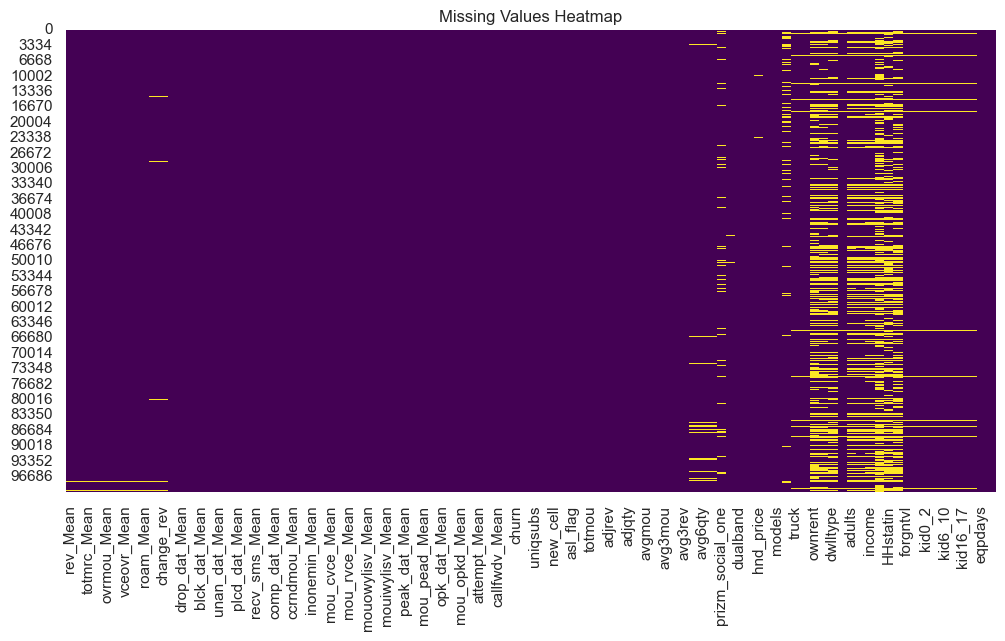

In [10]:
# Heatmap to visualize missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

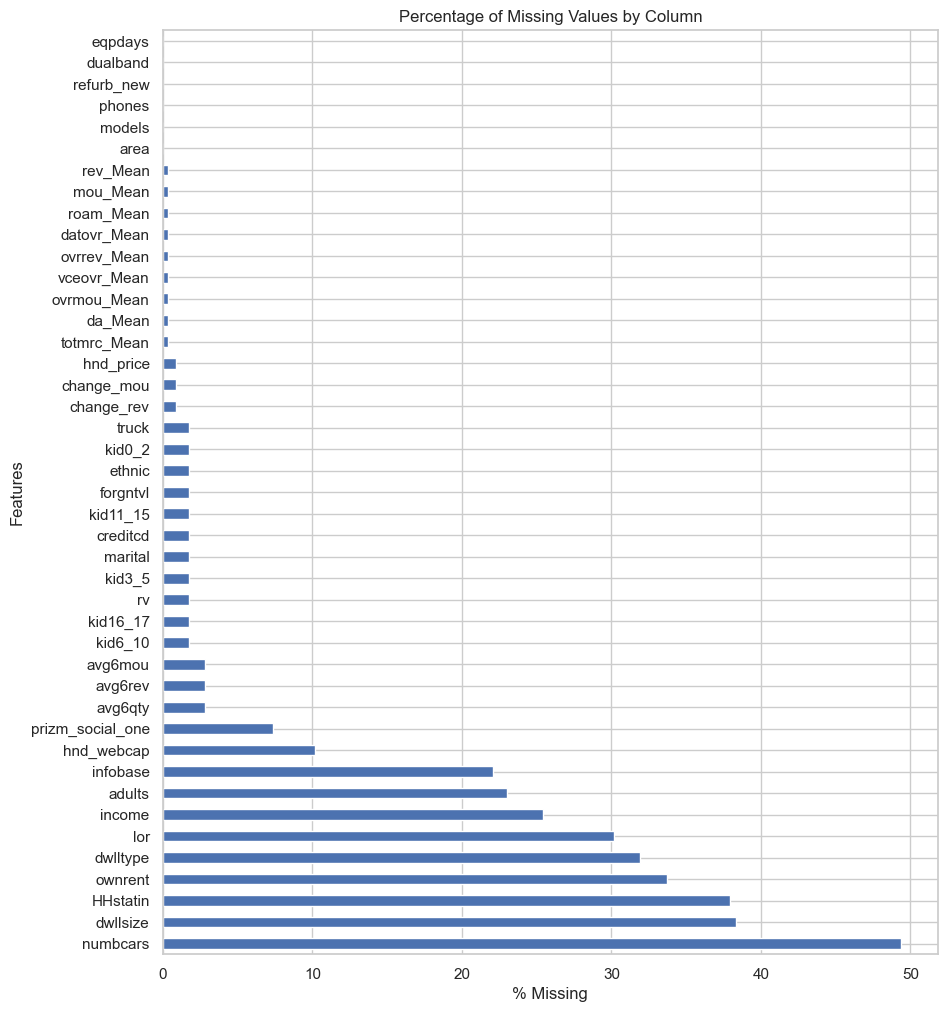

In [11]:
# Plot missing values by column as bar chart
missing_percent[missing_percent > 0].plot(kind='barh', figsize=(10, 12))
plt.title("Percentage of Missing Values by Column")
plt.xlabel("% Missing")
plt.ylabel("Features")
plt.show()

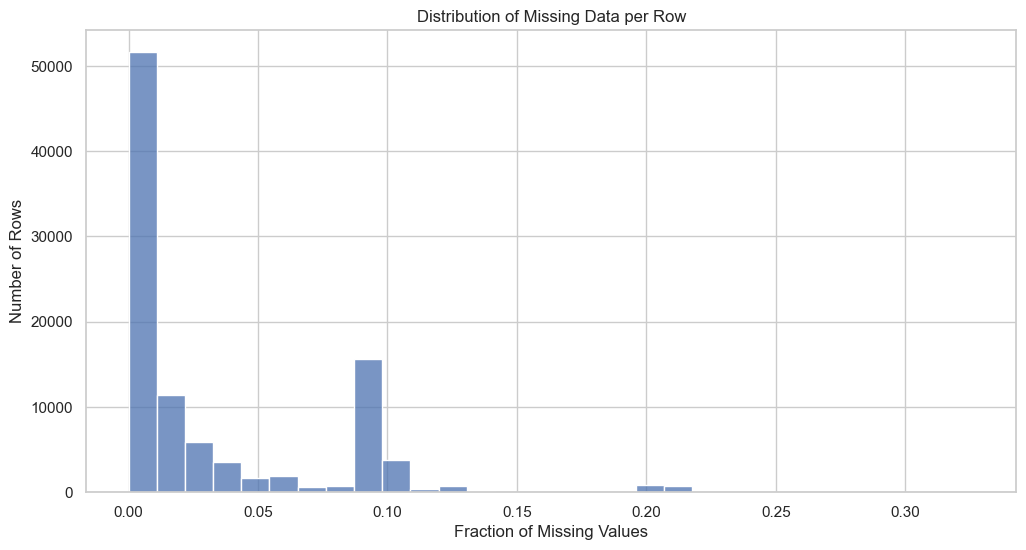

In [12]:
# Percentage of missing values per row
row_missing_pct = df_clean.isnull().mean(axis=1)
sns.histplot(row_missing_pct, bins=30, kde=False)
plt.title("Distribution of Missing Data per Row")
plt.xlabel("Fraction of Missing Values")
plt.ylabel("Number of Rows")
plt.show()

In [13]:
# Drop 'numbcars' due to excessive missingness
df_clean = df_clean.drop(columns=['numbcars'], errors='ignore')

In [14]:
# Rebuild numerical and categorical lists
numerical_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_clean.select_dtypes(include='object').columns.tolist()

In [15]:
# Fill Categorical Columns
for col in categorical_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode(dropna=True)[0])

In [16]:
# Impute Numeric Columns
imputer_num = IterativeImputer(random_state=42, max_iter=20)
df_clean[numerical_cols] = pd.DataFrame(imputer_num.fit_transform(df_clean[numerical_cols]), columns=numerical_cols, index=df_clean.index)

## Outliers

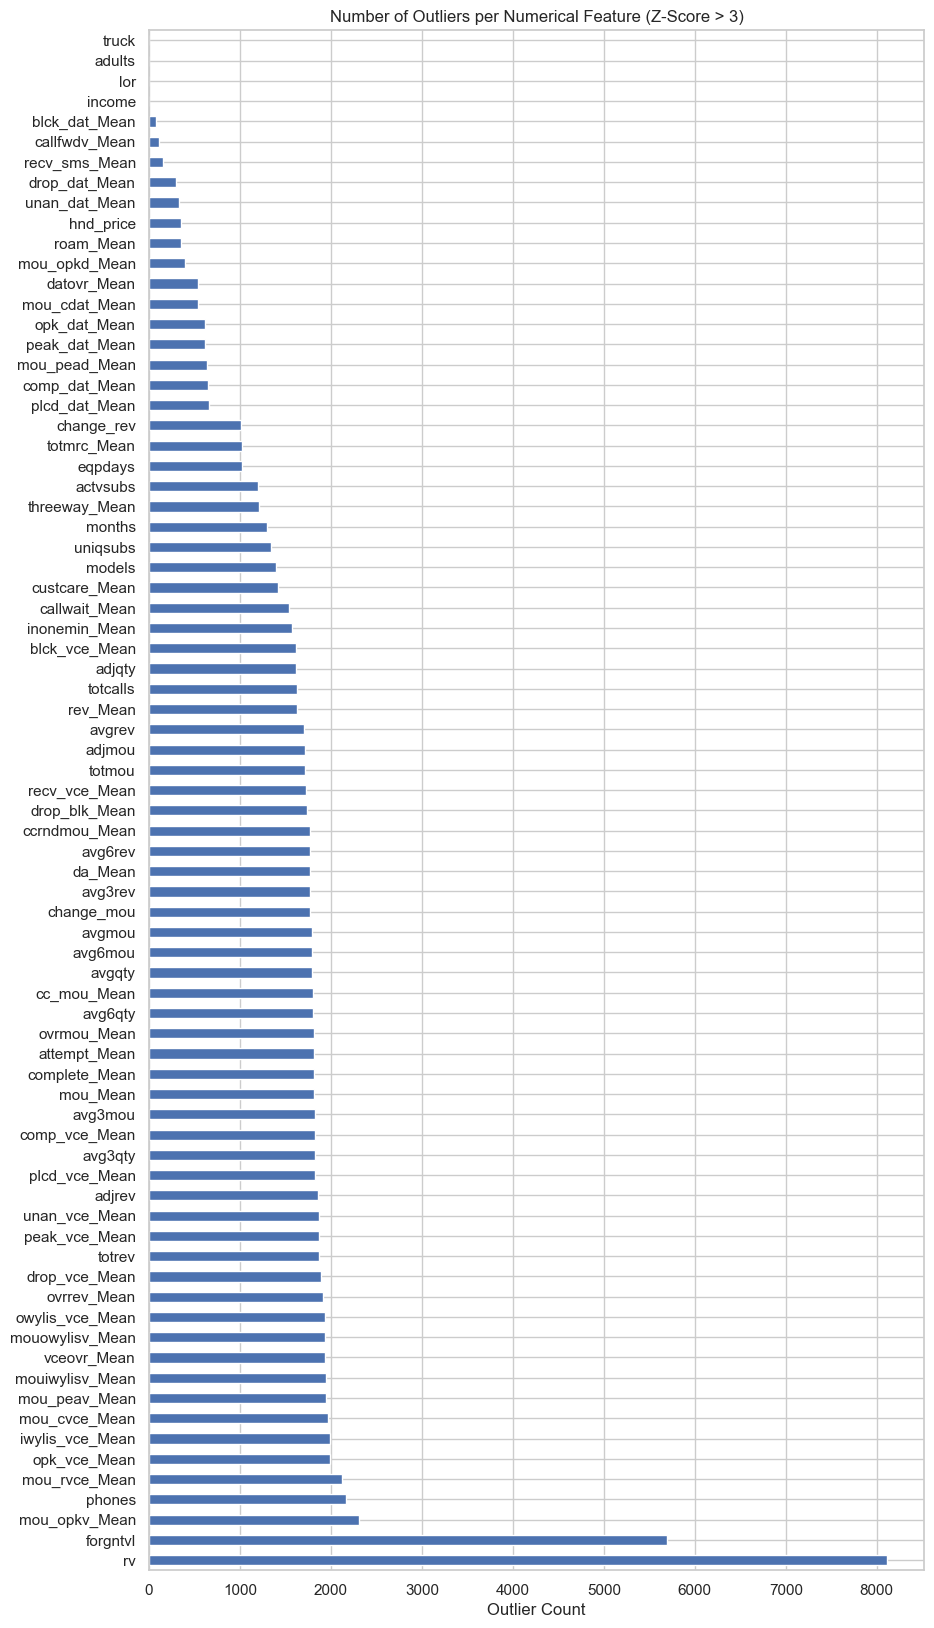

In [17]:
# Compute Z-scores
z_scores = np.abs(zscore(df_clean[numerical_cols], nan_policy='omit'))

# Count outliers per feature
outlier_counts = pd.Series((z_scores > 3).sum(axis=0), index=numerical_cols)

# Visualize
outlier_counts.sort_values(ascending=False).plot(kind='barh', figsize=(10, 20))
plt.title("Number of Outliers per Numerical Feature (Z-Score > 3)")
plt.xlabel("Outlier Count")
plt.show()

In [18]:
# Enhanced outlier impact scoring
outlier_stats = []

for col in numerical_cols:
    col_data = df_clean[col]
    col_z = pd.Series(zscore(col_data, nan_policy='omit'), index=col_data.index).abs()
    
    outliers = col_z > 3
    count = outliers.sum()
    total = len(col_z)
    outlier_pct = count / total
    
    if count > 0:
        mean_z = np.mean(col_z[outliers])
        max_z = np.max(col_z[outliers])
        skew_val = col_data.skew()

        impact_score = (outlier_pct * 100) * mean_z * abs(skew_val)

        outlier_stats.append({
            'column': col,
            'outlier_count': count,
            'outlier_pct': round(outlier_pct * 100, 2),
            'mean_z': round(mean_z, 2),
            'max_z': round(max_z, 2),
            'skew': round(skew_val, 2),
            'impact_score': round(impact_score, 2)
        })

# Create DataFrame and sort
outlier_impact_df = pd.DataFrame(outlier_stats).sort_values(by='impact_score', ascending=False)

# View top 30
print("High-impact outlier columns:\n")
display(outlier_impact_df.head(30))

High-impact outlier columns:



,column,outlier_count,outlier_pct,mean_z,max_z,skew,impact_score
8,roam_Mean,354,0.35,7.08,250.55,168.48,422.31
12,drop_dat_Mean,299,0.30,8.76,236.33,149.64,392.14
10,change_rev,1016,1.02,4.90,196.50,78.05,388.47
49,uniqsubs,1343,1.34,3.94,180.84,60.52,320.59
20,recv_sms_Mean,149,0.15,11.98,243.15,168.44,300.78
42,mou_opkd_Mean,396,0.40,9.75,164.39,67.44,260.44
7,datovr_Mean,539,0.54,8.25,135.63,58.11,258.44
16,unan_dat_Mean,327,0.33,9.26,164.27,81.81,247.69
14,blck_dat_Mean,77,0.08,13.96,277.34,224.60,241.39
38,mou_pead_Mean,635,0.64,8.52,123.11,43.00,232.61


In [19]:
impact_threshold = 75
high_impact_cols = outlier_impact_df[outlier_impact_df['impact_score'] > impact_threshold]['column'].tolist()

# Apply winsorization only to those columns
for col in high_impact_cols:
    lower = df_clean[col].quantile(0.01)
    upper = df_clean[col].quantile(0.99)
    df_clean[col] = np.clip(df_clean[col], lower, upper)

print("Winsorized high-impact outlier columns:", high_impact_cols)

Winsorized high-impact outlier columns: ['roam_Mean', 'drop_dat_Mean', 'change_rev', 'uniqsubs', 'recv_sms_Mean', 'mou_opkd_Mean', 'datovr_Mean', 'unan_dat_Mean', 'blck_dat_Mean', 'mou_pead_Mean', 'mou_cdat_Mean', 'custcare_Mean', 'plcd_dat_Mean', 'opk_dat_Mean', 'comp_dat_Mean', 'peak_dat_Mean', 'callfwdv_Mean', 'threeway_Mean', 'change_mou', 'ccrndmou_Mean', 'da_Mean', 'cc_mou_Mean', 'callwait_Mean', 'blck_vce_Mean', 'forgntvl', 'rv']


## Feature Engineering

In [20]:
# Helpers
def safe_divide(numerator, denominator):
    # Return 0 if denominator == 0 to avoid inf / NaN.
    return np.where(denominator == 0, 0, numerator / denominator)

def pct_change_to_float(series):
    # Convert percent strings to float
    return series.str.rstrip('%').astype(float) / 100.0

### Revenue and Usage

In [21]:
# rev_per_mou - Average revenue collected for every minute of use. High values mean the customer pays a lot for each minute.
df_clean['rev_per_mou'] = safe_divide(df_clean['rev_Mean'], df_clean['mou_Mean'])

# ovrrev_ratio - Fraction of total revenue that is overage revenue. Large ratios suggest a user often exceeds their plan.
df_clean['ovrrev_ratio'] = safe_divide(df_clean['ovrrev_Mean'], df_clean['rev_Mean'])

# totmrc_ratio - Share of predictable recurring charges in overall revenue. Low values means more variable, usage-driven bills.
df_clean['totmrc_ratio'] = safe_divide(df_clean['totmrc_Mean'], df_clean['rev_Mean'])

# rev_change_abs - Recent % change in monthly revenue. Positive growth vs. decline flags emerging behaviour.
df_clean['rev_change_abs'] = df_clean['change_rev']

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_4944\3197193208.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean['rev_change_abs'] = df_clean['change_rev']


### Call Quality Indicators

In [22]:
# drop_rate - Proportion of voice calls that drop before connecting.
df_clean['drop_rate'] = safe_divide(df_clean['drop_vce_Mean'], df_clean['plcd_vce_Mean'])

# block_rate - Share of voice calls that never start because the network is busy.
df_clean['block_rate'] = safe_divide(df_clean['blck_vce_Mean'], df_clean['plcd_vce_Mean'])

# unan_rate - Fraction of voice calls that ring but are never answered.
df_clean['unan_rate'] = safe_divide(df_clean['unan_vce_Mean'], df_clean['plcd_vce_Mean'])

# call_fail_rate - Overall call attempts (voice or data) that end in drop/block.
df_clean['call_fail_rate'] = safe_divide(df_clean['drop_blk_Mean'], df_clean['attempt_Mean'])

# completion_rate - Percentage of attempted calls that complete successfully.
df_clean['completion_rate'] = safe_divide(df_clean['complete_Mean'], df_clean['attempt_Mean'])

# short_call_ratio - Share of outbound calls lasting < 1 minute. Often flags accidental dials or quick info checks.
df_clean['short_call_ratio'] = safe_divide(df_clean['inonemin_Mean'], df_clean['plcd_vce_Mean'])

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_4944\3447707668.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean['drop_rate'] = safe_divide(df_clean['drop_vce_Mean'], df_clean['plcd_vce_Mean'])
C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_4944\3447707668.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean['block_rate'] = safe_divide(df_clean['blck_vce_Mean'], df_clean['plcd_vce_Mean'])
C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_4944\3447707668.py:8: PerformanceWarning: DataFrame is highly fragm

### Time of the Day Usage

In [23]:
# peak_voice_rati - Portion of all voice minutes that occur during peak hours. Peak minutes are costlier and stress the network.
df_clean['peak_voice_ratio'] = safe_divide(df_clean['mou_peav_Mean'], df_clean['mou_Mean'])

# offpeak_voice_ratio - Complement: voice minutes made off-peak. High off-peak usage implies price-sensitive behaviour.
df_clean['offpeak_voice_ratio'] = safe_divide(df_clean['mou_opkv_Mean'], df_clean['mou_Mean'])

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_4944\2275870719.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean['peak_voice_ratio'] = safe_divide(df_clean['mou_peav_Mean'], df_clean['mou_Mean'])
C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_4944\2275870719.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean['offpeak_voice_ratio'] = safe_divide(df_clean['mou_opkv_Mean'], df_clean['mou_Mean'])


### Short Term Trends

In [24]:
# delta_mou_3m - Change in average minutes last 3 month vs. last 6 month. Positive values mean recent growth in usage.
df_clean['delta_mou_3m'] = df_clean['avg3mou'] - df_clean['avg6mou']

# delta_rev_3m - Same concept for revenue; captures recent spend swings.
df_clean['delta_rev_3m'] = df_clean['avg3rev'] - df_clean['avg6rev']

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_4944\2517693346.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean['delta_mou_3m'] = df_clean['avg3mou'] - df_clean['avg6mou']
C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_4944\2517693346.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean['delta_rev_3m'] = df_clean['avg3rev'] - df_clean['avg6rev']


### Lifetime Normalised Metrics

In [25]:
# life_call_rate - Average calls per month over the customer’s tenure.
df_clean['life_call_rate'] = safe_divide(df_clean['totcalls'], df_clean['months'])

# life_mou_rate - Average minutes per month across full tenure.
df_clean['life_mou_rate'] = safe_divide(df_clean['totmou'], df_clean['months'])

# avg_call_duration - Typical length (minutes) of an individual call.
df_clean['avg_call_duration'] = safe_divide(df_clean['avgmou'], df_clean['avgqty'])

# adj_call_efficiency - Minutes per call based on billed (adjusted) figures, smoothing out rounding/discounts etc.
df_clean['adj_call_efficiency'] = safe_divide(df_clean['adjmou'], df_clean['adjqty'])

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_4944\654789380.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean['life_call_rate'] = safe_divide(df_clean['totcalls'], df_clean['months'])
C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_4944\654789380.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean['life_mou_rate'] = safe_divide(df_clean['totmou'], df_clean['months'])
C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_4944\654789380.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usual

## Univariate Analysis and Skew

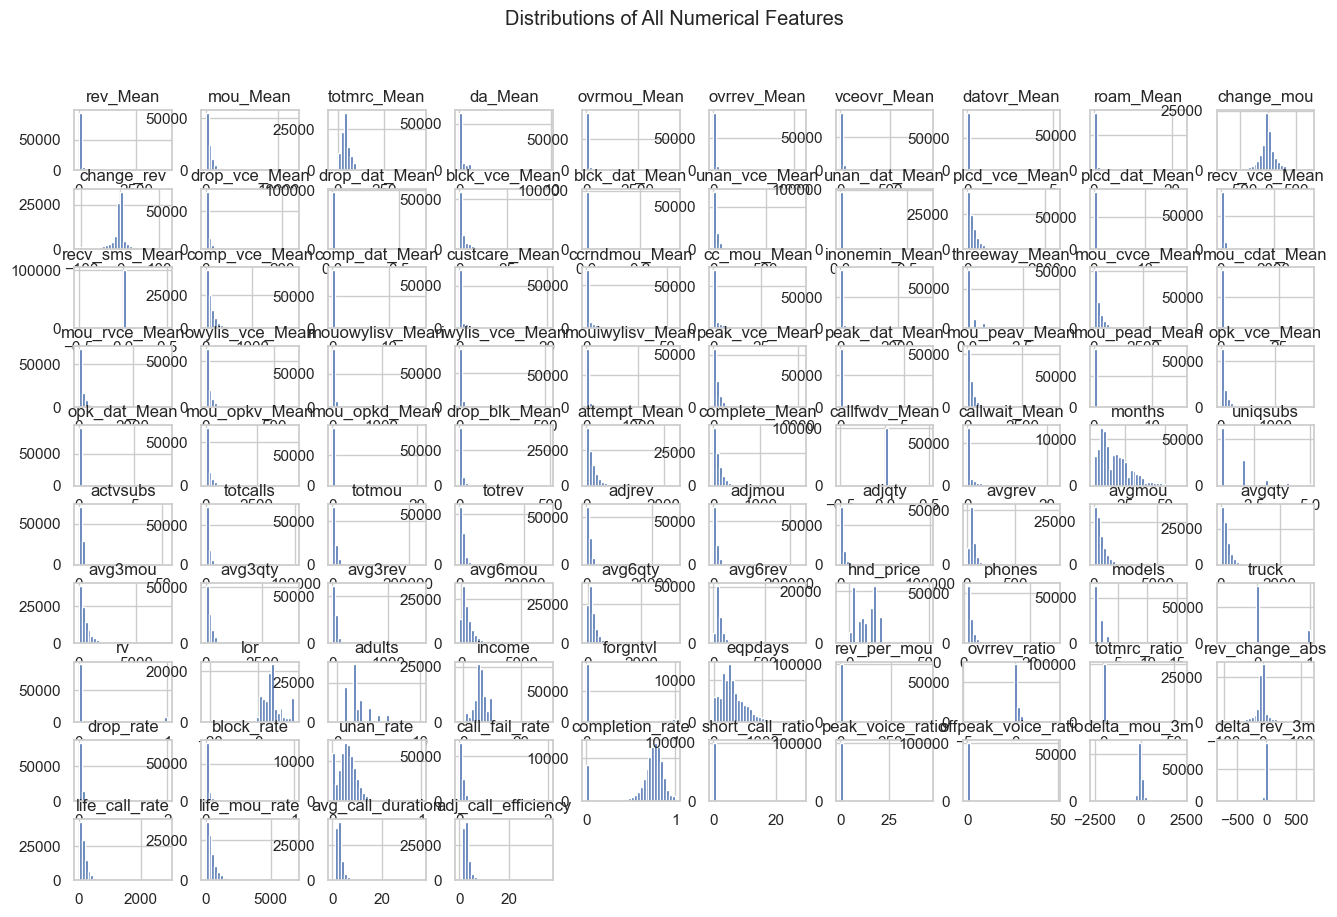

In [26]:
# Select numeric columns
numerical_cols = df_clean.select_dtypes(include=['number']).columns.tolist()

# Histograms of all numeric columns
df_clean[numerical_cols].hist(bins=30, figsize=(16, 10))
plt.suptitle("Distributions of All Numerical Features")
plt.show()

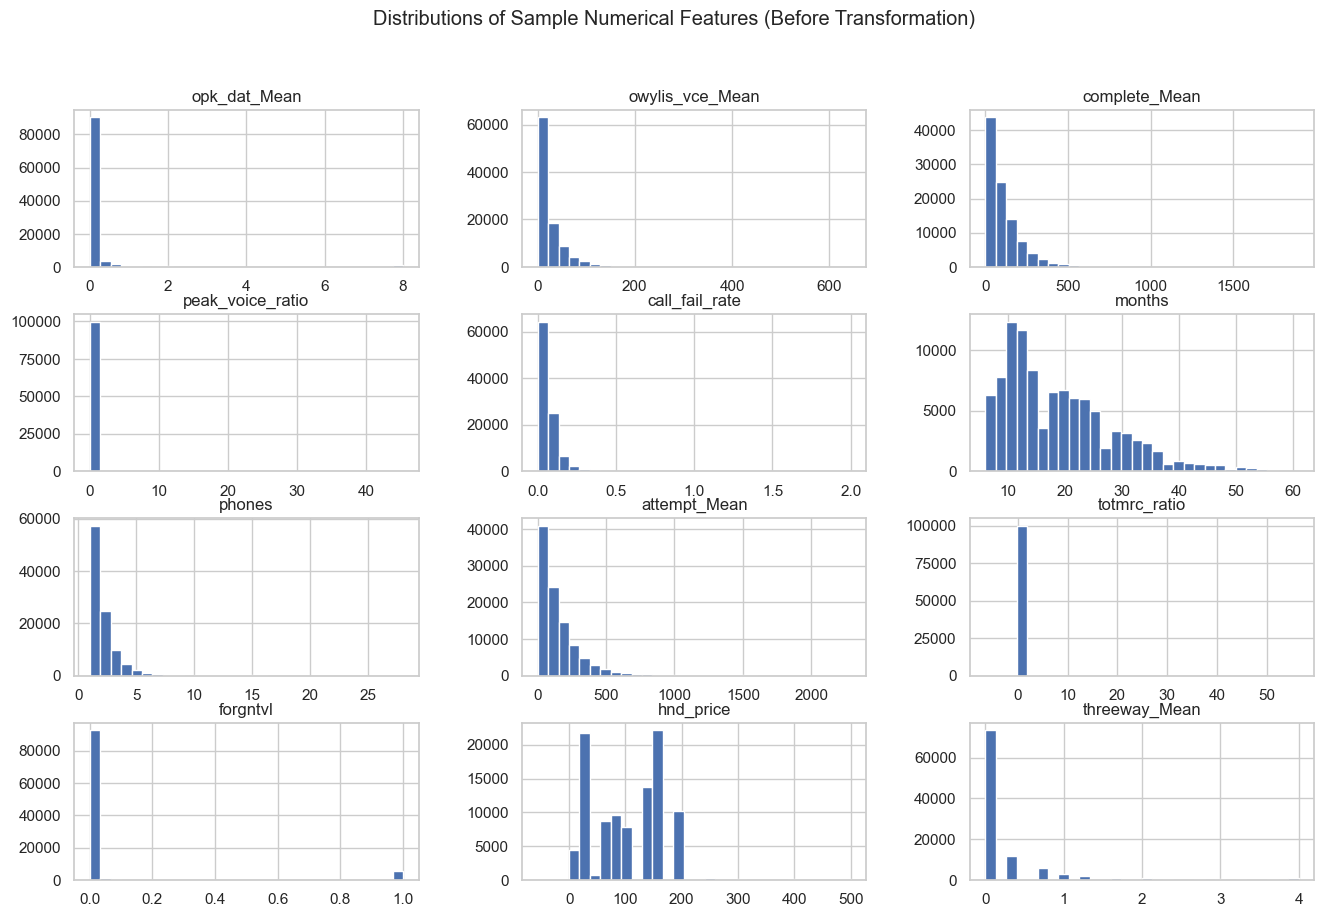

In [27]:
# Plot histograms of random numeric sample
sample_num = df_clean[numerical_cols].sample(
    n=min(12, len(numerical_cols)), axis=1, random_state=1
)

sample_num.hist(bins=30, figsize=(16, 10))
plt.suptitle("Distributions of Sample Numerical Features (Before Transformation)")
plt.show()

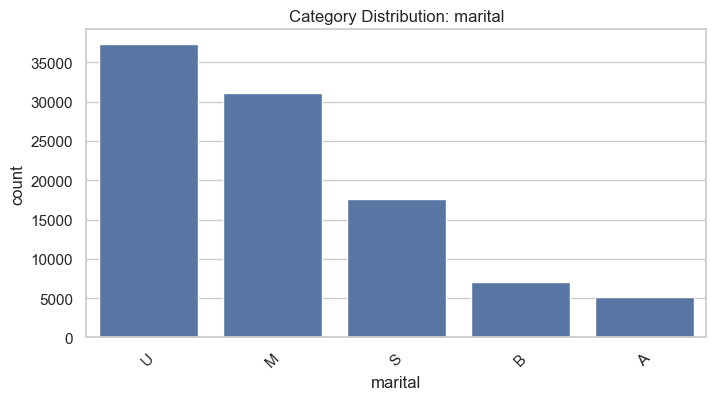

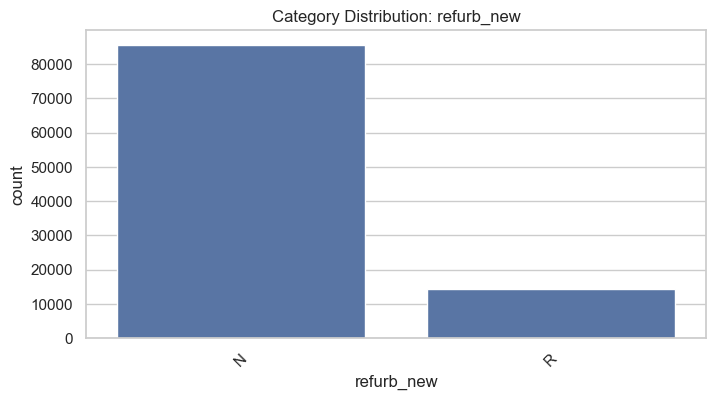

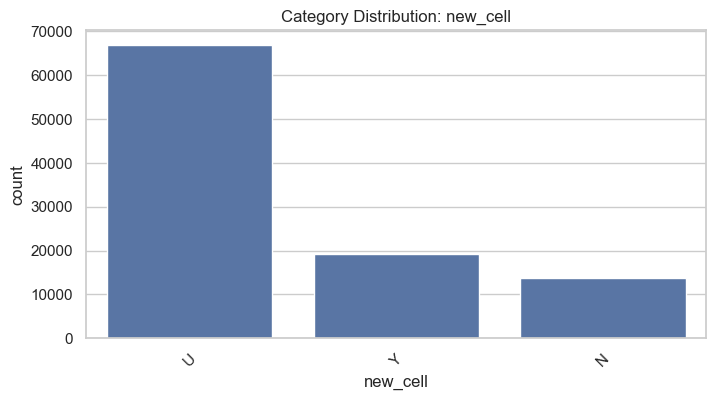

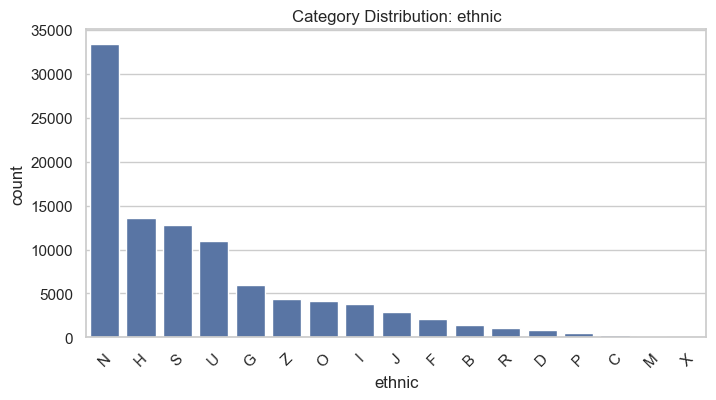

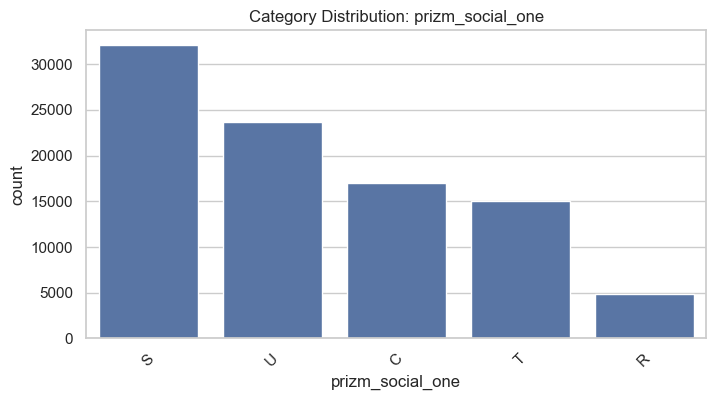

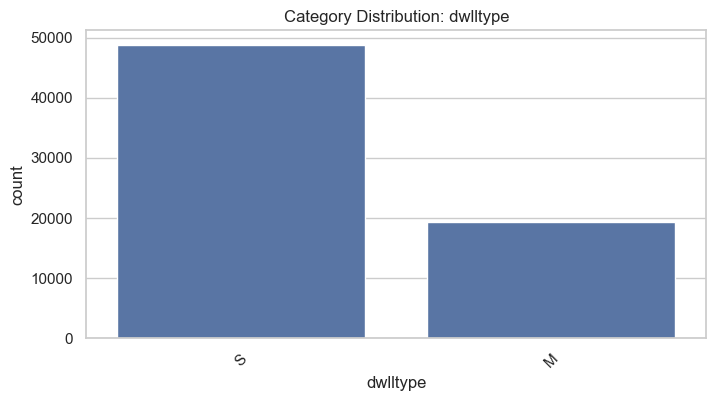

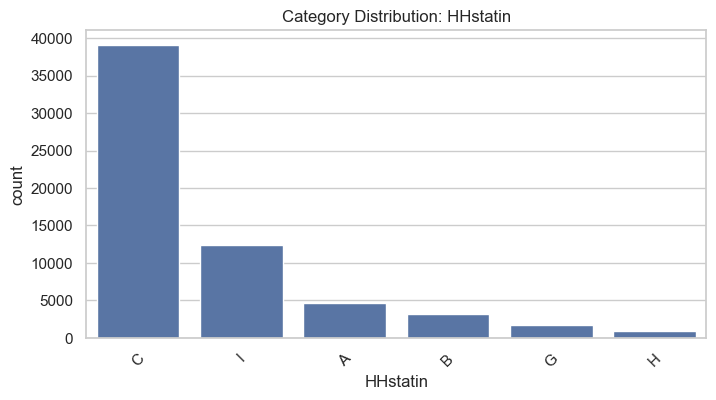

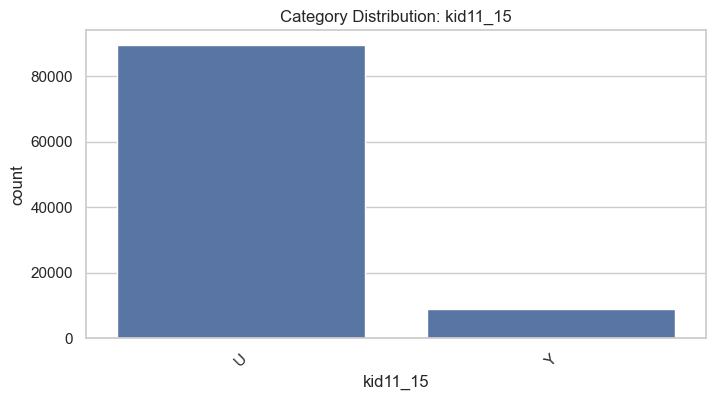

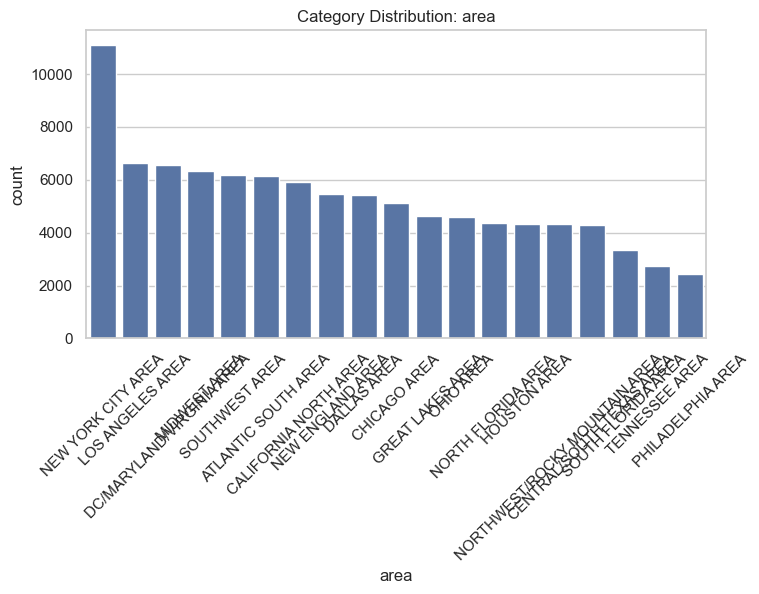

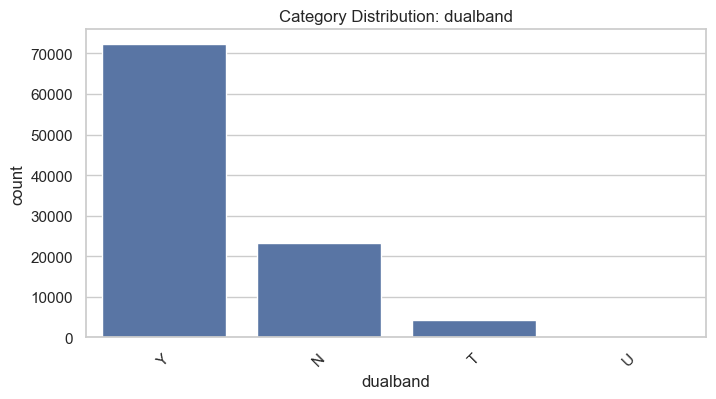

In [28]:
# Plot distribution of random categorical columns
sample_cat = df_clean[categorical_cols].sample(n=min(10, len(categorical_cols)), axis=1, random_state=2)

# Plot countplots for each
for col in sample_cat.columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f"Category Distribution: {col}")
    plt.show()

In [29]:
# Skewness
skew_values = df_clean[numerical_cols].skew().sort_values(ascending=False)
print("Top Skewed Features:\n", skew_values.head(70))

Top Skewed Features:
 offpeak_voice_ratio    76.150316
peak_voice_ratio       60.484801
totmrc_ratio           41.478044
rev_per_mou            31.501075
short_call_ratio       30.907692
                         ...    
attempt_Mean            2.641527
comp_vce_Mean           2.625488
complete_Mean           2.619507
mou_cvce_Mean           2.564346
models                  2.431126
Length: 70, dtype: float64


In [30]:
high_skew_cols = skew_values[skew_values > 1].index.tolist()
print(f"\nTotal number of skewed columns with skewness > 1: {len(high_skew_cols)}")


Total number of skewed columns with skewness > 1: 84


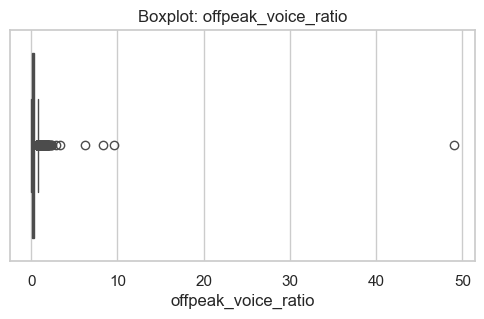

In [31]:
# Boxplot of the most skewed column
top_skewed_col = high_skew_cols[0]
plt.figure(figsize=(6, 3))
sns.boxplot(x=df_clean[top_skewed_col])
plt.title(f"Boxplot: {top_skewed_col}")
plt.show()

In [32]:
# Apply QuantileTransformer to correct skewness
qt = QuantileTransformer(output_distribution='normal', random_state=42)
df_clean[high_skew_cols] = pd.DataFrame(qt.fit_transform(df_clean[high_skew_cols]), columns=high_skew_cols, index=df_clean.index)

## Categorical Features and Encoding

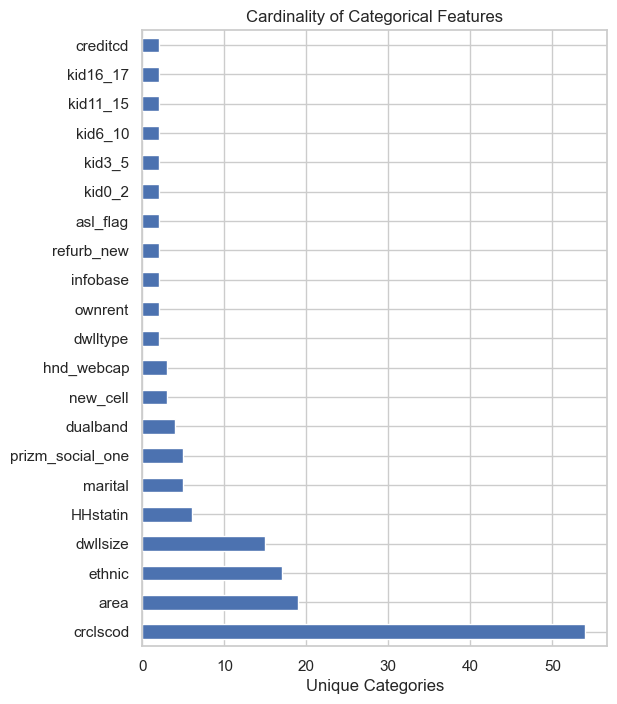

In [33]:
# Unique value counts for categorical features
cat_cardinality = df_clean[categorical_cols].nunique().sort_values(ascending=False)

# Plot cardinality
cat_cardinality.plot(kind='barh', figsize=(6, 8))
plt.title("Cardinality of Categorical Features")
plt.xlabel("Unique Categories")
plt.show()

In [34]:
# Preview Cardinality Distributions
for col in categorical_cols:
    print(f"\n{col} value counts:")
    print(df_clean[col].value_counts(dropna=False).head(10))


new_cell value counts:
new_cell
U    66914
Y    19301
N    13785
Name: count, dtype: int64

crclscod value counts:
crclscod
AA    36509
A     16996
BA    12667
CA     8334
EA     6419
B      4110
DA     3669
ZA     3493
C      1456
A2      861
Name: count, dtype: int64

asl_flag value counts:
asl_flag
N    86064
Y    13936
Name: count, dtype: int64

prizm_social_one value counts:
prizm_social_one
S    39485
U    23613
C    17018
T    14989
R     4895
Name: count, dtype: int64

area value counts:
area
NEW YORK CITY AREA           11138
LOS ANGELES AREA              6636
DC/MARYLAND/VIRGINIA AREA     6567
MIDWEST AREA                  6346
SOUTHWEST AREA                6187
ATLANTIC SOUTH AREA           6132
CALIFORNIA NORTH AREA         5913
NEW ENGLAND AREA              5452
DALLAS AREA                   5426
CHICAGO AREA                  5141
Name: count, dtype: int64

dualband value counts:
dualband
Y    72266
N    23196
T     4316
U      222
Name: count, dtype: int64

refurb_new va

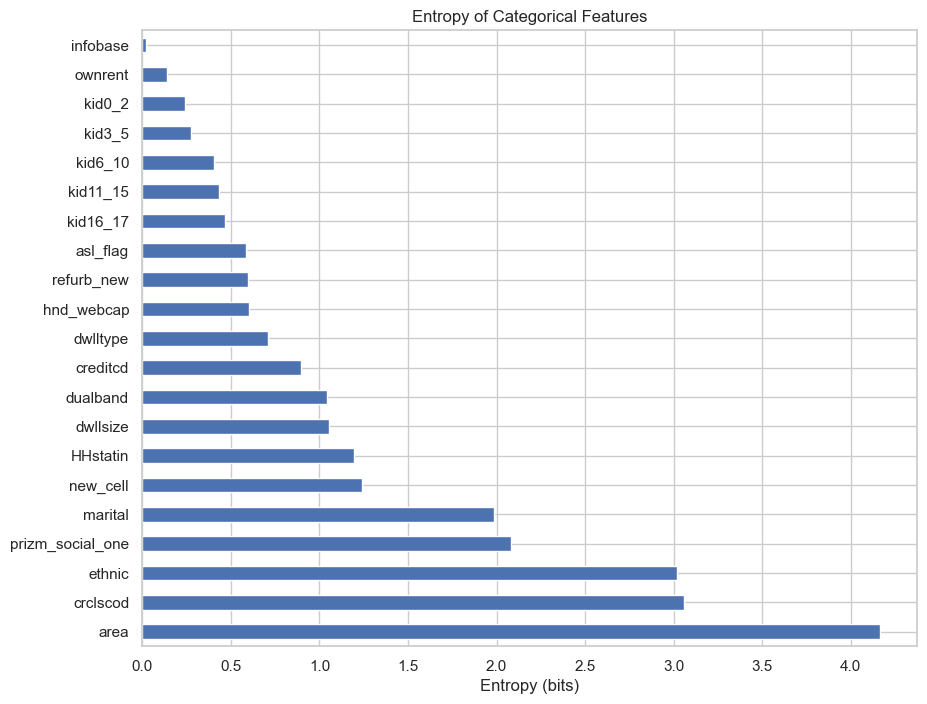

In [35]:
def entropy_score(series):
    probs = series.value_counts(normalize=True)
    return entropy(probs, base=2)

entropy_values = df_clean[categorical_cols].apply(entropy_score).sort_values(ascending=False)

# Plot entropy scores
entropy_values.plot(kind='barh', figsize=(10, 8))
plt.title("Entropy of Categorical Features")
plt.xlabel("Entropy (bits)")
plt.show()

In [36]:
# Combine cardinality & entropy for decision
cat_summary = pd.DataFrame({
    "Cardinality": cat_cardinality,
    "Entropy": entropy_values
}).sort_values(by="Entropy", ascending=False)

display(cat_summary.head(35))

,Cardinality,Entropy
area,19,4.167016
crclscod,54,3.056727
ethnic,17,3.020497
prizm_social_one,5,2.079296
marital,5,1.986486
new_cell,3,1.239998
HHstatin,6,1.194592
dwllsize,15,1.055936
dualband,4,1.042894
creditcd,2,0.893566


In [37]:
# Manually defined column group 1 - Ordinal Features
ordinal_cols = ['lor','HHstatin', 'dwllsize', 'income', 'crclscod']
'''
lor: Length of residence might be ordinal as it is a categorical value for length.
crclscod: Credit class codes might represent a ranking of creditworthiness.
dwllsize: Dwelling size codes might mean increasing size.
HHstatin: Household status codes could mean a tiered status.
income: Most probably would be ordinal as its categorical value for income.
'''

'\nlor: Length of residence might be ordinal as it is a categorical value for length.\ncrclscod: Credit class codes might represent a ranking of creditworthiness.\ndwllsize: Dwelling size codes might mean increasing size.\nHHstatin: Household status codes could mean a tiered status.\nincome: Most probably would be ordinal as its categorical value for income.\n'

In [38]:
# Manually defined column group 2,3 - Nominal, Binary Features
nominal_cols = ['prizm_social_one', 'area', 'marital', 'ethnic', 'ownrent', 'dwlltype', 'infobase', 'hnd_webcap', 'dualband', 'new_cell']
binary_cols = ['asl_flag', 'creditcd', 'refurb_new', 'kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'truck', 'rv']

# All categorical features for preprocessing
categorical_cols_final = ordinal_cols + nominal_cols + binary_cols

### Nominal Encoding

In [39]:
nominal_encoding_strategy = {}
encoded_onehot_cols = []
encoded_freq_cols = []
encoded_hash_cols = []

# Step 1: Define strategy per column based on cardinality & entropy
for col in nominal_cols:
    if col in cat_summary.index:
        card = cat_summary.loc[col, "Cardinality"]
        ent = cat_summary.loc[col, "Entropy"]

        if card < 10:
            nominal_encoding_strategy[col] = 'onehot'
        elif card > 50 and ent > 2.0:
            nominal_encoding_strategy[col] = 'hash'
        else:
            nominal_encoding_strategy[col] = 'frequency'
    else:
        nominal_encoding_strategy[col] = 'frequency'

In [40]:
# One-hot
onehot_cols = [col for col, method in nominal_encoding_strategy.items() if method == 'onehot']
if onehot_cols:
    df_ohe = pd.get_dummies(df_clean[onehot_cols], drop_first=True)
    encoded_onehot_cols = df_ohe.columns.tolist()
    df_clean = pd.concat([df_clean.drop(columns=onehot_cols), df_ohe], axis=1)

In [41]:
# Frequency
freq_cols = [col for col, method in nominal_encoding_strategy.items() if method == 'frequency']
for col in freq_cols:
    if col in df_clean.columns:
        freq_map = df_clean[col].value_counts(normalize=True)
        df_clean[col] = df_clean[col].map(freq_map).fillna(0)
encoded_freq_cols = freq_cols

In [42]:
# Feature Hashing
hash_cols = [col for col, method in nominal_encoding_strategy.items() if method == 'hash']
for col in hash_cols:
    if col in df_clean.columns:
        hasher = FeatureHasher(n_features=8, input_type='string')
        hashed = hasher.transform(df_clean[col].astype(str))
        hashed_df = pd.DataFrame(hashed.toarray(), index=df_clean.index)
        hashed_df.columns = [f"{col}_hash_{i}" for i in range(hashed_df.shape[1])]
        df_clean = pd.concat([df_clean.drop(columns=col), hashed_df], axis=1)
        encoded_hash_cols.extend(hashed_df.columns.tolist())

In [43]:
encoded_categorical_cols = encoded_onehot_cols + encoded_freq_cols + encoded_hash_cols

### Ordinal Hashing

In [44]:
ordinal_encoder = OrdinalEncoder()
df_clean[ordinal_cols] = pd.DataFrame(ordinal_encoder.fit_transform(df_clean[ordinal_cols]), columns=ordinal_cols, index=df_clean.index)

In [45]:
encoded_categorical_cols += ordinal_cols

### Binary Features

In [46]:
binary_map = {'Y': 1, 'N': 0, 'U': 0, np.nan: 0}
for col in binary_cols:
    if df_clean[col].dtype == 'object':
        df_clean[col] = df_clean[col].map(binary_map).astype('float32')

In [47]:
encoded_categorical_cols += binary_cols

In [48]:
# Reconstruct numerical block
numerical_cols_final = [col for col in df_clean.columns if col not in encoded_categorical_cols + ['churn', 'Customer_ID']]

In [49]:
# Ensure numeric format for encoded columns
df_clean[encoded_categorical_cols] = df_clean[encoded_categorical_cols].apply(pd.to_numeric, errors='coerce')
df_clean[encoded_categorical_cols] = df_clean[encoded_categorical_cols].fillna(0)

## Multivariate Analysis

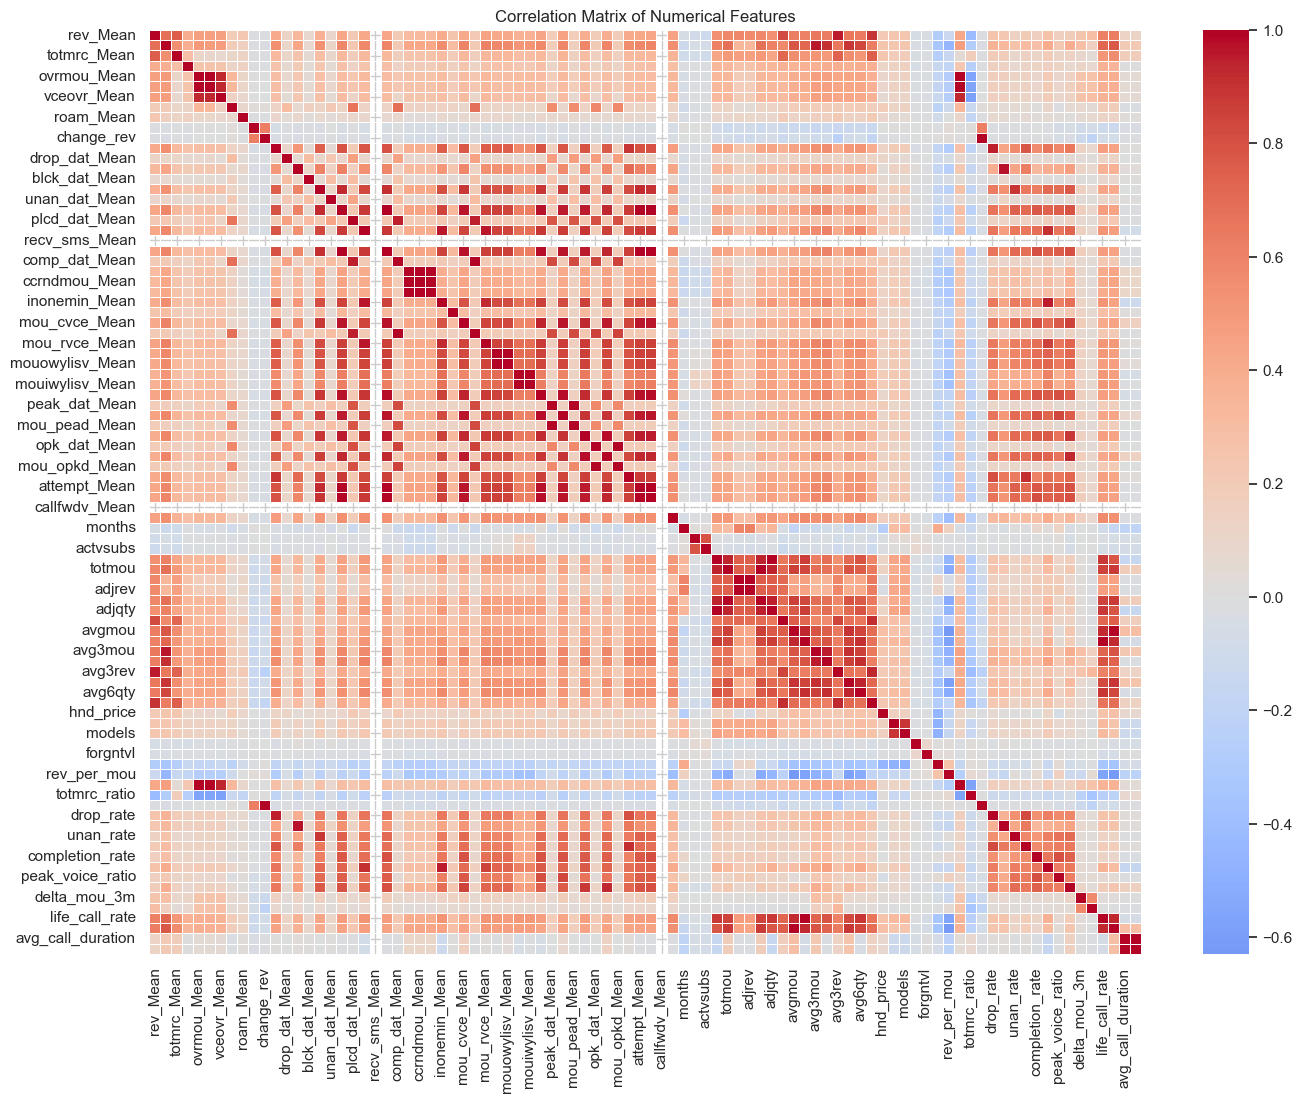

In [50]:
# Correlation matrix for numerical features
corr_matrix = df_clean[numerical_cols_final].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [51]:
# Absolute correlations and flatten
corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
# Remove self-correlations
corr_pairs = corr_pairs[corr_pairs < 1]

# Display top redundant pairs
print("Top Correlated Feature Pairs:\n", corr_pairs.drop_duplicates().head(50))

Top Correlated Feature Pairs:
 adj_call_efficiency  avg_call_duration    0.999999
attempt_Mean         plcd_vce_Mean        0.999528
comp_vce_Mean        complete_Mean        0.999277
totcalls             adjqty               0.999122
adjmou               totmou               0.999081
cc_mou_Mean          ccrndmou_Mean        0.998759
ovrmou_Mean          ovrrev_Mean          0.998478
ovrrev_Mean          ovrrev_ratio         0.996706
comp_dat_Mean        mou_cdat_Mean        0.996276
mouiwylisv_Mean      iwylis_vce_Mean      0.995341
mou_pead_Mean        peak_dat_Mean        0.995056
totrev               adjrev               0.994908
ovrrev_ratio         ovrmou_Mean          0.994819
opk_dat_Mean         mou_opkd_Mean        0.994673
custcare_Mean        ccrndmou_Mean        0.991877
complete_Mean        attempt_Mean         0.991474
plcd_vce_Mean        comp_vce_Mean        0.991291
life_mou_rate        avgmou               0.991236
plcd_vce_Mean        complete_Mean        0.991000


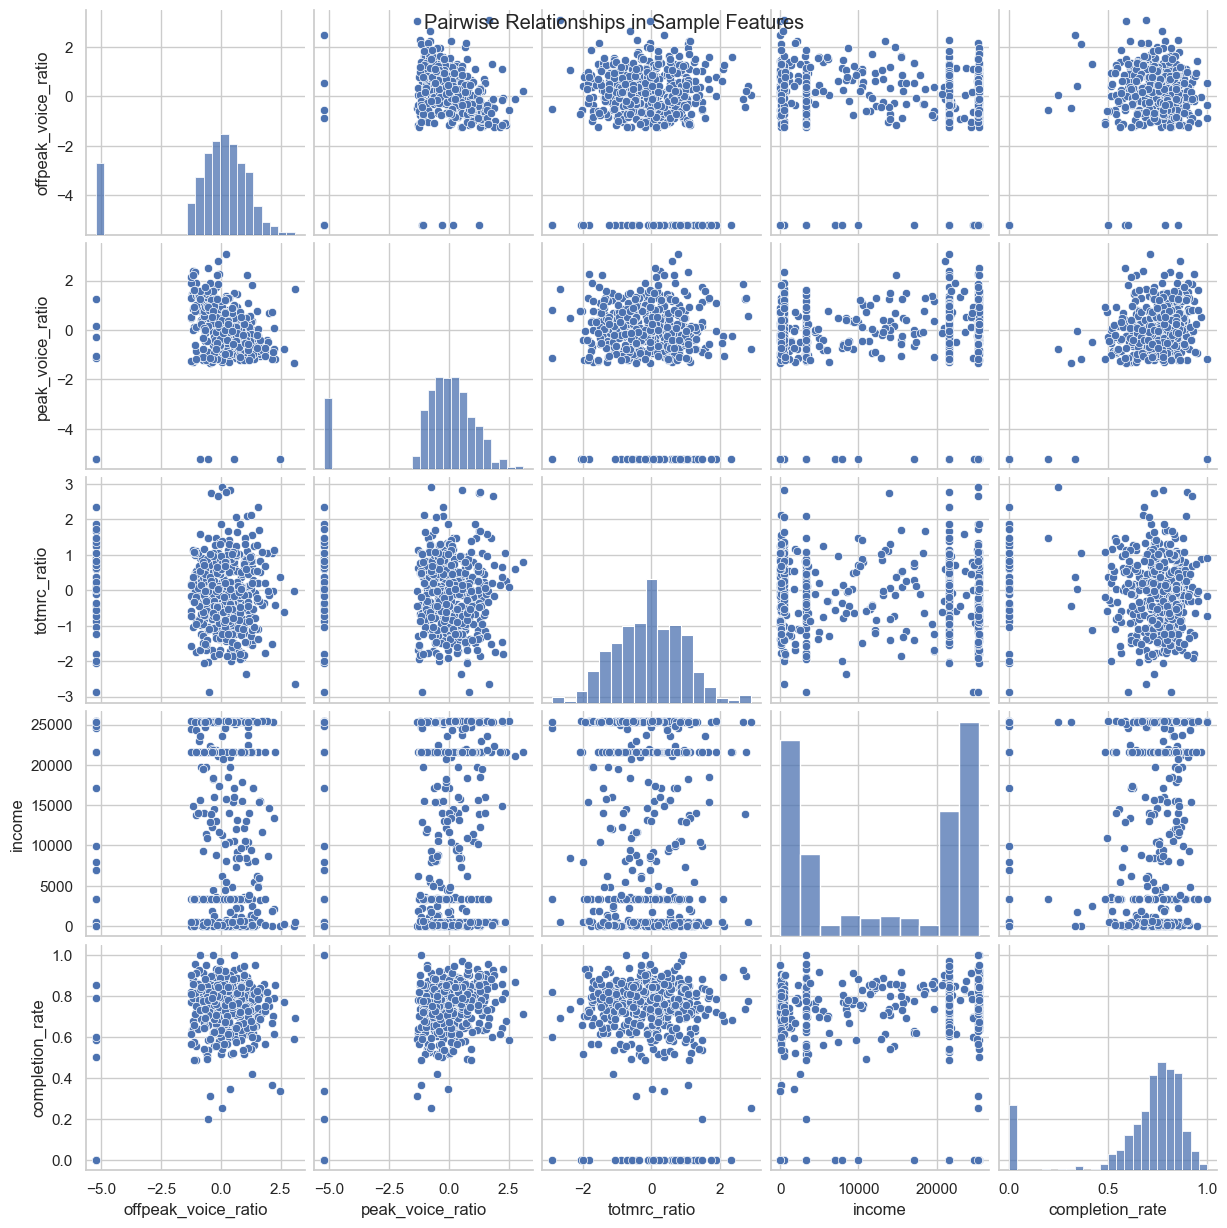

In [52]:
# Pairplot
sample_cols = skew_values.head(3).index.tolist() + skew_values.tail(2).index.tolist()
sns.pairplot(df_clean[sample_cols].dropna().sample(n=500, random_state=42))
plt.suptitle("Pairwise Relationships in Sample Features")
plt.show()

In [53]:
# Total revenue across different marital statuses
if 'marital' in df_clean.columns and 'totrev' in df_clean.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_clean, x='marital', y='totrev')
    plt.xticks(rotation=45)
    plt.title("Total Revenue by Marital Status")
    plt.show()

### Correlation pruning

In [54]:
def prune_correlated_features(df, threshold):
   
     # Step 1: Compute correlation matrix
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Step 2: Build a graph of highly correlated features
    G = nx.Graph()
    for col1 in upper.columns:
        for col2 in upper.index:
            if upper.loc[col2, col1] > threshold:
                G.add_edge(col1, col2)

    # Step 3: Score features by variance
    scores = df.var()

    # Step 4: Decide what to keep and drop per connected group
    to_keep = set()
    to_drop = set()

    for group in nx.connected_components(G):
        group = list(group)
        ranked = sorted(group, key=lambda x: scores.get(x, 0), reverse=True)
        keep_n = len(group) // 2
        to_keep.update(ranked[:keep_n])
        to_drop.update(ranked[keep_n:])

    final_drop = list(to_drop - to_keep)
    df_pruned = df.drop(columns=final_drop, errors='ignore')

    return df_pruned, final_drop, list(to_keep)

In [55]:
df_clean, dropped_features, kept_features = prune_correlated_features(df_clean, 0.95)

print("Dropped features:", dropped_features)
print("Kept features:", kept_features)
print("New shape:", df_clean.shape)

Dropped features: ['hnd_webcap_WC', 'ccrndmou_Mean', 'mou_rvce_Mean', 'adjrev', 'recv_vce_Mean', 'avg3mou', 'complete_Mean', 'mou_Mean', 'comp_dat_Mean', 'mou_cvce_Mean', 'mouowylisv_Mean', 'life_mou_rate', 'comp_vce_Mean', 'opk_dat_Mean', 'ovrmou_Mean', 'change_rev', 'totcalls', 'life_call_rate', 'totmou', 'plcd_vce_Mean', 'attempt_Mean', 'block_rate', 'peak_dat_Mean', 'iwylis_vce_Mean', 'adj_call_efficiency', 'rev_Mean', 'cc_mou_Mean', 'ovrrev_Mean']
Kept features: ['inonemin_Mean', 'avg_call_duration', 'rev_change_abs', 'peak_vce_Mean', 'mouiwylisv_Mean', 'avgqty', 'short_call_ratio', 'adjqty', 'mou_cdat_Mean', 'avg3rev', 'opk_vce_Mean', 'avgmou', 'mou_pead_Mean', 'adjmou', 'mou_opkv_Mean', 'custcare_Mean', 'ovrrev_ratio', 'mou_opkd_Mean', 'hnd_webcap_WCMB', 'mou_peav_Mean', 'blck_vce_Mean', 'avg3qty', 'owylis_vce_Mean', 'totrev']
New shape: (100000, 97)


## Feature Scaling

In [56]:
# Final sets
all_numeric = df_clean.select_dtypes(include='number').columns.tolist()
numerical_scaled_cols = [col for col in all_numeric if col not in encoded_categorical_cols]
categorical_scaled_cols = [col for col in encoded_categorical_cols if col in df_clean.columns]

### Scale Numerical Features (RobustScaler)

In [57]:
scaler_num = RobustScaler()
df_clean[numerical_scaled_cols] = pd.DataFrame(scaler_num.fit_transform(df_clean[numerical_scaled_cols]), columns=numerical_scaled_cols, index=df_clean.index)

### Scale Categoricals

In [58]:
scaler_cat = MaxAbsScaler()
df_clean[categorical_scaled_cols] = pd.DataFrame(scaler_cat.fit_transform(df_clean[categorical_scaled_cols]), columns=categorical_scaled_cols, index=df_clean.index)

In [59]:
print("Remaining object columns:", df_clean.select_dtypes(include='object').columns.tolist())
df_clean.describe().T

Remaining object columns: []


,count,mean,std,min,25%,50%,75%,max
totmrc_Mean,100000.0,-0.054810,0.699932,-3.710358,-0.506192,0.0,0.493808,3.599127
da_Mean,100000.0,-0.373916,0.516971,-0.896890,-0.896890,0.0,0.103110,0.849122
vceovr_Mean,100000.0,-0.352033,0.511644,-0.888004,-0.888004,0.0,0.111996,0.880323
datovr_Mean,100000.0,0.981322,2.457490,0.000000,0.000000,0.0,0.000000,10.398675
roam_Mean,100000.0,0.341405,0.512401,0.000000,0.000000,0.0,1.000000,1.771052
...,...,...,...,...,...,...,...,...
dualband_T,100000.0,0.043160,0.203218,0.000000,0.000000,0.0,0.000000,1.000000
dualband_U,100000.0,0.002220,0.047065,0.000000,0.000000,0.0,0.000000,1.000000
dualband_Y,100000.0,0.722660,0.447688,0.000000,0.000000,1.0,1.000000,1.000000
new_cell_U,100000.0,0.669140,0.470525,0.000000,0.000000,1.0,1.000000,1.000000


## Check Block Magnitude of Features

In [60]:
numerical_final = numerical_scaled_cols
categorical_final = categorical_scaled_cols

In [61]:
X_num = df_clean[numerical_final].values
X_cat = df_clean[categorical_final].values

num_power = np.mean(np.square(X_num))
cat_power = np.mean(np.square(X_cat))

print(f"Numerical Block Power: {num_power:.4f}")
print(f"Categorical Block Power: {cat_power:.4f}")
print(f"Ratio (cat/num): {cat_power / num_power:.2f}")

Numerical Block Power: 1.8301
Categorical Block Power: 0.2782
Ratio (cat/num): 0.15


In [63]:
df_clean.to_csv("./Data/telecom_preprocessed.csv", index=False)

In [64]:
df_balanced = df_clean.copy()

# Now apply the exact scaling to only the categorical block in the new copy
X_num = df_balanced[numerical_final].values
X_cat = df_balanced[categorical_final].values

num_power = np.mean(np.square(X_num))
cat_power = np.mean(np.square(X_cat))

scaling_exact = np.sqrt(num_power / cat_power)
print("Scaling factor applied to df_balanced:", scaling_exact)

df_balanced[categorical_final] *= scaling_exact

Scaling factor applied to df_balanced: 2.564785825607361


In [67]:
X_cat_scaled = df_balanced[categorical_final].values
cat_power_new = np.mean(np.square(X_cat_scaled))
display(f'New Ratio (cat/num): {cat_power_new / num_power:.2f}')

'New Ratio (cat/num): 1.00'

In [68]:
selected_columns = df_clean[numerical_final]
display(selected_columns)

,totmrc_Mean,da_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,...,drop_rate,unan_rate,call_fail_rate,completion_rate,short_call_ratio,peak_voice_ratio,offpeak_voice_ratio,delta_mou_3m,delta_rev_3m,avg_call_duration
0,-0.898939,0.000000,-0.888004,0.000000,0.000000,-1.008333,-0.515403,0.0,-0.030832,0.0,...,-0.460982,-0.361340,-0.548307,0.713244,0.860965,0.994073,0.017027,-0.604651,-0.864220,-0.076802
1,-0.327933,0.000000,0.080611,0.000000,0.000000,3.588333,0.537567,0.0,0.000000,0.0,...,0.054244,0.530450,-0.317874,-0.159448,0.375230,-0.734318,0.397947,-2.023256,-0.864220,-0.972574
2,-1.002023,-0.896890,-0.888004,0.000000,0.000000,0.011667,-0.636120,0.0,-0.880419,0.0,...,0.181244,0.949102,-0.283596,-0.628168,-0.577547,0.618604,-0.890928,-0.011628,0.000000,0.331839
3,-0.320043,-0.896890,-0.888004,0.000000,0.000000,0.030000,-3.660700,0.0,-0.880419,0.0,...,-3.832835,-3.889042,-3.870181,1.686136,0.915578,0.414527,1.551311,-0.511628,-0.459644,-0.600284
4,0.814119,-0.896890,-0.888004,0.000000,0.000000,0.296667,0.627305,0.0,-0.030832,0.0,...,0.312445,1.245317,-0.080843,-0.978610,0.721742,-0.167675,0.513192,-0.348837,-1.395981,0.364408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.310592,0.066422,0.107379,6.630423,1.211241,0.002199,-0.172043,0.0,-0.880419,0.0,...,0.170836,-0.196645,-0.292107,0.500761,-0.626888,-0.959367,-0.236915,-2.267442,-1.440823,-0.094280
99996,0.150824,0.132944,0.107798,6.628899,1.221758,0.125121,0.000000,0.0,0.000000,0.0,...,0.307871,0.106154,0.125580,0.083925,0.042422,-0.076410,-0.941092,-0.348837,0.517404,-0.189513
99997,-0.115099,0.092079,0.106950,6.633461,1.099213,-1.263047,-3.660700,0.0,-0.880419,0.0,...,-3.832835,-3.889042,-3.870181,-5.256777,-3.810567,-3.906202,-3.814621,-0.604651,-0.999482,1.659045
99998,1.364490,0.243948,0.108071,6.618623,0.000000,-1.954644,1.039055,0.0,-0.030832,0.0,...,0.109549,0.388433,-0.325483,0.001860,1.082841,1.218899,0.073653,1.000000,-1.213290,-0.582518


# Clusterability Analysis

### Hopkins Score

In [71]:
def hopkins(X, sample_size=10000):
    if len(X) > sample_size:
        X = X[np.random.choice(X.shape[0], sample_size, replace=False)]
    n, d = X.shape
    nbrs = NearestNeighbors(n_neighbors=2).fit(X)  # <- request 2 neighbors now

    # Uniform random points in same feature space
    rand_pts = np.random.uniform(X.min(axis=0), X.max(axis=0), (n, d))
    u_dist, _ = nbrs.kneighbors(rand_pts)

    # Distance to the 2nd nearest neighbor for real points
    x_dist, _ = nbrs.kneighbors(X)
    return u_dist[:, 0].sum() / (u_dist[:, 0].sum() + x_dist[:, 1].sum())

# Compute Hopkins
hopkins_score = hopkins(df_clean.values)
display(f"Hopkins Score: {hopkins_score:.3f}")

'Hopkins Score: 0.813'

### PCA for Intrinsic Dimensionality

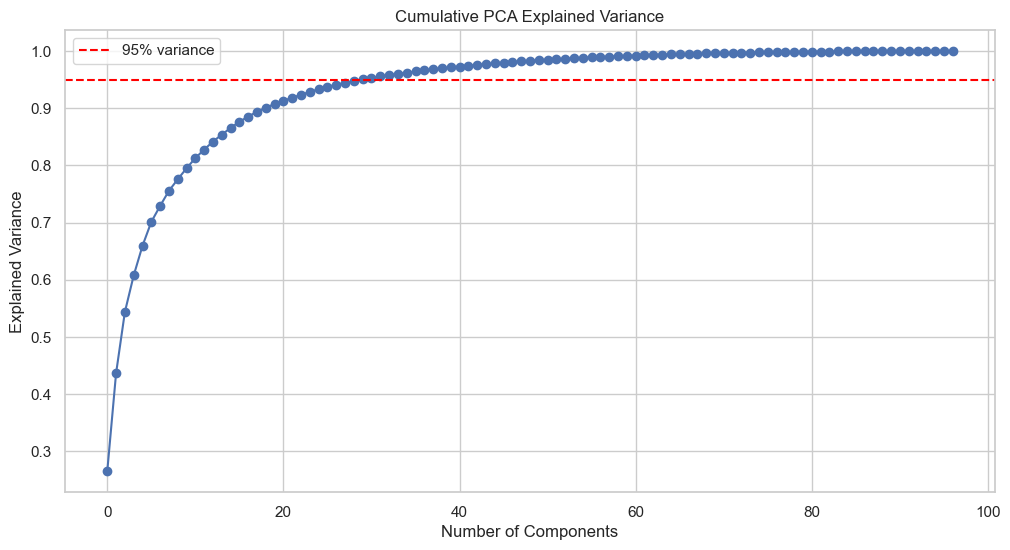

Intrinsic dimensionality for 95% variance: 30 components


In [72]:
pca = PCA().fit(df_clean.values)
explained = np.cumsum(pca.explained_variance_ratio_)
dim_95 = int(np.argmax(explained >= 0.95) + 1)

# Plot
plt.plot(explained, marker='o')
plt.axhline(0.95, color='red', linestyle='--', label='95% variance')
plt.title("Cumulative PCA Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.legend()
plt.show()

print(f"Intrinsic dimensionality for 95% variance: {dim_95} components")

### Kurtosis Analysis (Tail/Outlier Sensitivity)

Constant columns (3):
['recv_sms_Mean', 'callfwdv_Mean', 'refurb_new']


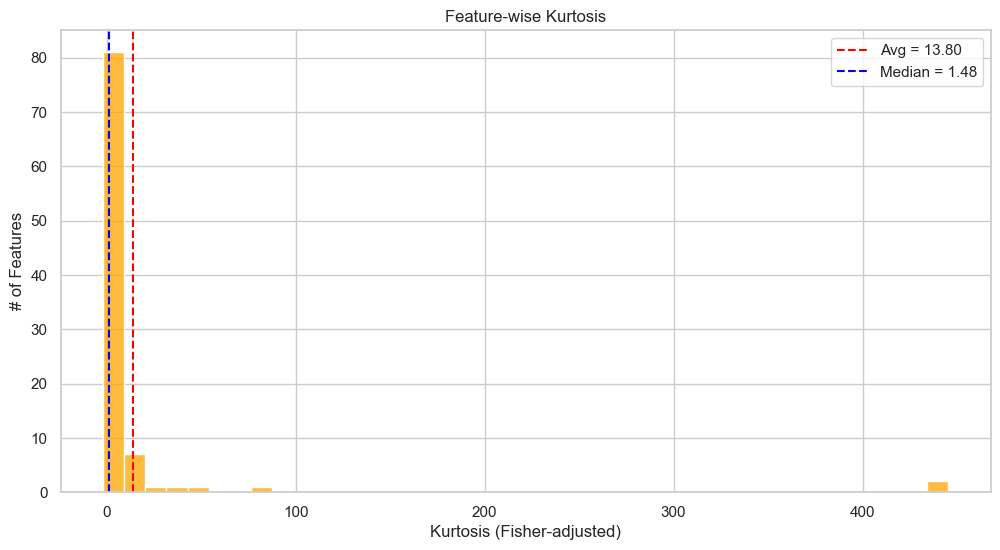

Average kurtosis: 13.80
Median kurtosis: 1.48
Features with kurtosis > 10: 12 / 94


In [81]:
# Select numeric columns
numeric_df = df_clean.select_dtypes(include=[np.number])

# Identify constant columns
constant_cols = numeric_df.columns[numeric_df.nunique() <= 1]
print(f"Constant columns ({len(constant_cols)}):")
print(list(constant_cols))

# Drop them
numeric_df = numeric_df.drop(columns=constant_cols)

# Now compute kurtosis
kurt_vals = kurtosis(numeric_df.values, axis=0, fisher=True, nan_policy='omit')

# Summary statistics
avg_kurt = float(np.mean(kurt_vals))
median_kurt = float(np.median(kurt_vals))
high_kurt_count = int(np.sum(kurt_vals > 10))

# Plot distribution
sns.histplot(kurt_vals, bins=40, color='orange')
plt.title("Feature-wise Kurtosis")
plt.xlabel("Kurtosis (Fisher-adjusted)")
plt.ylabel("# of Features")
plt.axvline(avg_kurt, color='red', linestyle='--', label=f'Avg = {avg_kurt:.2f}')
plt.axvline(median_kurt, color='blue', linestyle='--', label=f'Median = {median_kurt:.2f}')
plt.legend()
plt.grid(True)
plt.show()

# Print stats
print(f"Average kurtosis: {avg_kurt:.2f}")
print(f"Median kurtosis: {median_kurt:.2f}")
print(f"Features with kurtosis > 10: {high_kurt_count} / {len(kurt_vals)}")

In [99]:
def binarize_high_kurtosis_columns(df, kurt_threshold=10, unique_threshold=5):
    numeric_df = df.select_dtypes(include=[float, int])
    numeric_df = numeric_df.loc[:, numeric_df.nunique() > 1]

    kurt_vals = kurtosis(numeric_df.values, axis=0, fisher=True, nan_policy='omit')
    kurt_series = pd.Series(kurt_vals, index=numeric_df.columns)

    binary_candidates = [
        col for col in numeric_df.columns
        if kurt_series[col] > kurt_threshold and numeric_df[col].nunique() <= unique_threshold
    ]

    print(f"Binarized columns (replaced): {binary_candidates}")

    for col in binary_candidates:
        df.loc[:, col] = (df[col] > 0).astype(float)  # Safe assignment

    return df

In [100]:
df_clean = binarize_high_kurtosis_columns(df_clean)

Binarized columns (replaced): ['drop_dat_Mean', 'blck_dat_Mean', 'unan_dat_Mean', 'kid0_2', 'kid3_5', 'prizm_social_one_R', 'ownrent_R', 'infobase_N', 'dualband_T', 'dualband_U']


### GAP Statistic

In [110]:
def compute_gap_statistic(X, n_refs=10, max_k=10):
    shape = X.shape
    tops = X.max(axis=0)
    bots = X.min(axis=0)
    dists = tops - bots

    refs = np.random.rand(n_refs, shape[0], shape[1])
    for i in range(n_refs):
        refs[i] = refs[i] * dists + bots

    gaps = np.zeros(max_k - 1)
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k + 1, random_state=42).fit(X)
        disp = np.sum(np.min(pairwise_distances(X, kmeans.cluster_centers_), axis=1))

        ref_disps = np.zeros(n_refs)
        for i in range(n_refs):
            kmeans_ref = KMeans(n_clusters=k + 1, random_state=42).fit(refs[i])
            ref_disp = np.sum(np.min(pairwise_distances(refs[i], kmeans_ref.cluster_centers_), axis=1))
            ref_disps[i] = ref_disp

        gap = np.log(np.mean(ref_disps)) - np.log(disp)
        gaps[k - 1] = gap

    return gaps

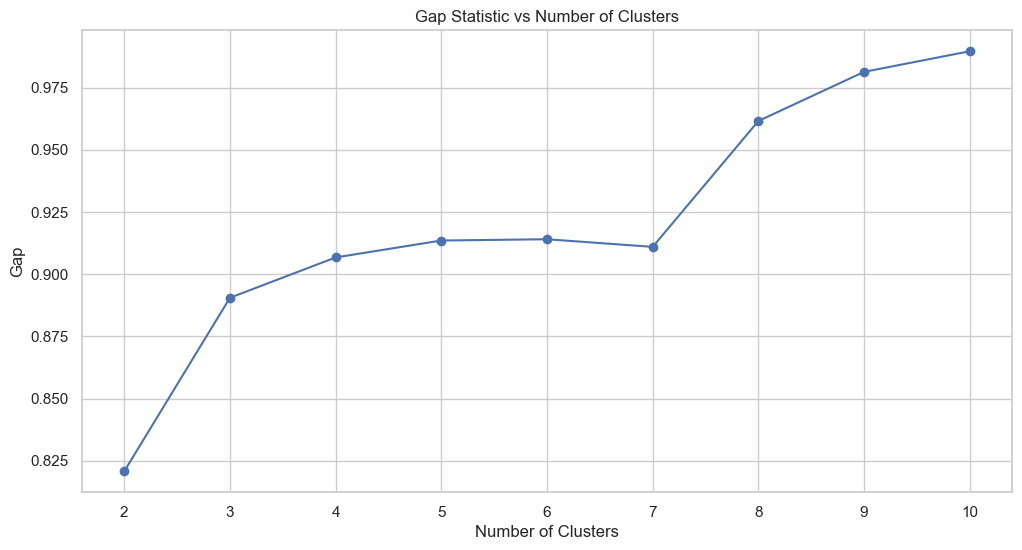

In [111]:
gaps = compute_gap_statistic(df_clean.values, n_refs=10, max_k=10)
plt.plot(range(2, 11), gaps, marker='o')
plt.title("Gap Statistic vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Gap")
plt.grid(True)
plt.show()

### DIP Test for Multimodality

In [107]:
proj = PCA(n_components=1).fit_transform(df_clean.values).flatten()
dip, pval = diptest(proj)
print(f"Dip Statistic: {dip:.4f}, p-value: {pval:.4f}")
print("Likely multimodal" if pval < 0.05 else "Possibly unimodal")

Dip Statistic: 0.0184, p-value: 0.0000
Likely multimodal


C:\Users\Eden Thomas\.conda\envs\thesis\Lib\site-packages\diptest\consts.py:702: UserWarning: Sample size exceeds the maximum limit of 72000. Results may not be accurate with precomputed statistical values.
  warnings.warn(


### Local Intrinsic Dimensionality

In [112]:
def estimate_lid(X, k=20):
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
    distances, _ = nbrs.kneighbors(X)
    # Ignore the first column (distance to self = 0)
    distances = distances[:, 1:]

    # Estimate LID per point using Maximum Likelihood Estimator
    lids = -k / np.sum(np.log(distances / distances[:, -1].reshape(-1, 1) + 1e-12), axis=1)
    return lids

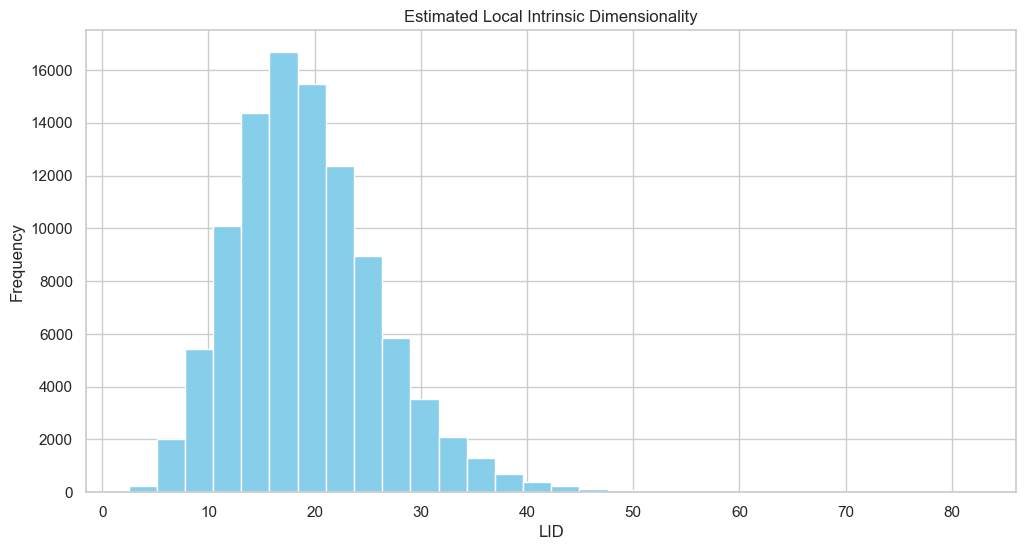

In [114]:
lid_scores = estimate_lid(df_clean.values, k=20)
plt.hist(lid_scores, bins=30, color='skyblue')
plt.title("Estimated Local Intrinsic Dimensionality")
plt.xlabel("LID")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### UMAP

C:\Users\Eden Thomas\.conda\envs\thesis\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Eden Thomas\.conda\envs\thesis\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


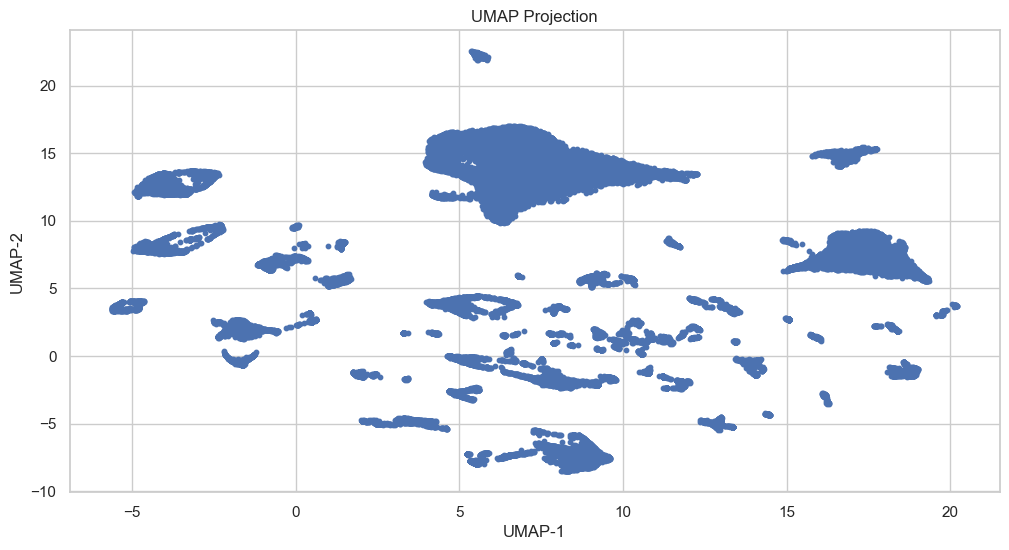

In [116]:
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_proj = umap_model.fit_transform(df_clean.values)
plt.scatter(umap_proj[:, 0], umap_proj[:, 1], s=10)
plt.title("UMAP Projection")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()

### t-SNE

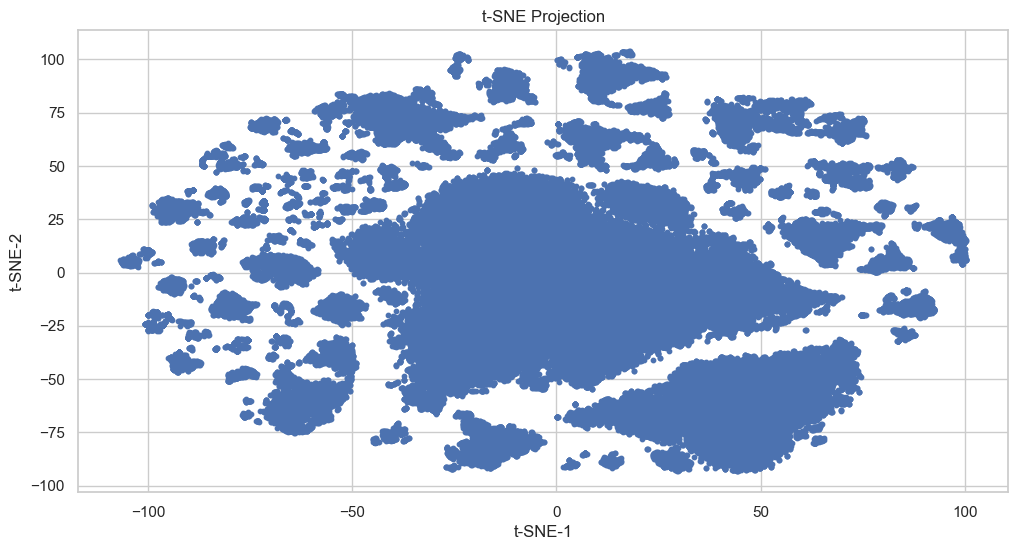

In [117]:

tsne_proj = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(df_clean.values)
plt.scatter(tsne_proj[:, 0], tsne_proj[:, 1], s=10)
plt.title("t-SNE Projection")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.grid(True)
plt.show()

### BIC/AIC

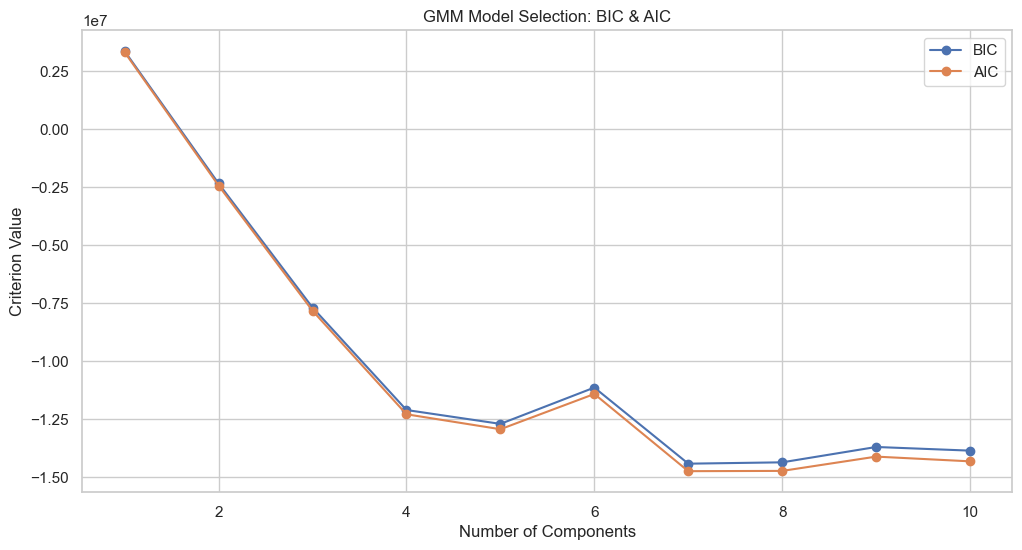

In [120]:
bic = []
aic = []
ks = range(1, 11)

for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(df_clean.values)
    bic.append(gmm.bic(X))
    aic.append(gmm.aic(X))

plt.plot(ks, bic, label='BIC', marker='o')
plt.plot(ks, aic, label='AIC', marker='o')
plt.title("GMM Model Selection: BIC & AIC")
plt.xlabel("Number of Components")
plt.ylabel("Criterion Value")
plt.legend()
plt.grid(True)
plt.show()

# Preliminary Clustering

In [121]:
X = df_clean.values

### KMEANS

In [122]:
k_values = range(2, 11)

# Store results
results = []

# Loop over k values
for k in k_values:
    try:
        km = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = km.fit_predict(X)

        # Compute clustering metrics
        sil = silhouette_score(X, labels)
        dbi = davies_bouldin_score(X, labels)
        chi = calinski_harabasz_score(X, labels)

        # Store the results
        results.append({
            "k": k,
            "silhouette": sil,
            "dbi": dbi,
            "chi": chi
        })

        # Print live progress
        print(f"Done: k={k}, silhouette={sil:.3f}, dbi={dbi:.3f}, chi={chi:.1f}")

    except Exception as e:
        print(f"Error at k={k}: {e}")

# Final DataFrame
df_kmeans_results = pd.DataFrame(results).sort_values(by="silhouette", ascending=False).reset_index(drop=True)
display(df_kmeans_results)

Done: k=2, silhouette=0.366, dbi=1.092, chi=24488.3
Done: k=3, silhouette=0.388, dbi=1.167, chi=31712.7
Done: k=4, silhouette=0.143, dbi=1.878, chi=25450.6
Done: k=5, silhouette=0.151, dbi=1.770, chi=22034.6
Done: k=6, silhouette=0.179, dbi=1.772, chi=19301.4
Done: k=7, silhouette=0.155, dbi=2.201, chi=16848.0
Done: k=8, silhouette=0.177, dbi=1.804, chi=17358.8
Done: k=9, silhouette=0.184, dbi=1.698, chi=17018.2
Done: k=10, silhouette=0.190, dbi=1.723, chi=15938.0


,k,silhouette,dbi,chi
0,3,0.388236,1.167146,31712.692571
1,2,0.366429,1.092433,24488.316471
2,10,0.190203,1.722751,15937.973971
3,9,0.184006,1.698382,17018.155014
4,6,0.179387,1.771534,19301.385009
5,8,0.177162,1.804221,17358.765910
6,7,0.154692,2.200938,16848.014848
7,5,0.151476,1.770284,22034.584000
8,4,0.143379,1.877659,25450.640621


### GMM

In [123]:
# k values to test
k_values = range(2, 11)

# Store results
results = []

# Loop over k values
for k in k_values:
    try:
        gmm = GaussianMixture(n_components=k, random_state=42)
        labels = gmm.fit_predict(X)

        # Compute clustering metrics
        sil = silhouette_score(X, labels)
        dbi = davies_bouldin_score(X, labels)
        chi = calinski_harabasz_score(X, labels)

        # Store result
        results.append({
            "k": k,
            "silhouette": sil,
            "dbi": dbi,
            "chi": chi
        })

        # Print live progress
        print(f"Done: k={k}, silhouette={sil:.3f}, dbi={dbi:.3f}, chi={chi:.1f}")

    except Exception as e:
        print(f"Error at k={k}: {e}")

# Final DataFrame
df_gmm_results = pd.DataFrame(results).sort_values(by="silhouette", ascending=False).reset_index(drop=True)
display(df_gmm_results)

Done: k=2, silhouette=0.085, dbi=2.601, chi=12094.8
Done: k=3, silhouette=0.168, dbi=1.888, chi=20794.8
Done: k=4, silhouette=0.105, dbi=2.738, chi=20502.7
Done: k=5, silhouette=0.095, dbi=3.135, chi=15525.9
Done: k=6, silhouette=0.160, dbi=3.189, chi=14179.0
Done: k=7, silhouette=0.081, dbi=5.094, chi=12186.8
Done: k=8, silhouette=0.112, dbi=2.983, chi=13332.1
Done: k=9, silhouette=0.153, dbi=3.037, chi=12526.3
Done: k=10, silhouette=0.157, dbi=3.145, chi=11522.7


,k,silhouette,dbi,chi
0,3,0.167749,1.888094,20794.775715
1,6,0.160119,3.188712,14178.967340
2,10,0.157189,3.144510,11522.695494
3,9,0.152631,3.037305,12526.257056
4,8,0.111740,2.983276,13332.105234
5,4,0.104951,2.738328,20502.723460
6,5,0.094837,3.134671,15525.855182
7,2,0.085355,2.600636,12094.750477
8,7,0.081061,5.094348,12186.783943


### BIRCH

In [141]:
# Manual threshold input
BIRCH_THRESHOLD = 5

# Run BIRCH
birch = Birch(n_clusters=None, threshold=BIRCH_THRESHOLD)
labels_birch = birch.fit_predict(X)
subcentres = birch.subcluster_centers_
n_sub = subcentres.shape[0]

print(f"Birch threshold={BIRCH_THRESHOLD} produced {n_sub} subclusters.\n")

Birch threshold=5 produced 2844 subclusters.



In [142]:
# KMeans on BIRCH subcluster centers
results = []
k_values = range(2, 11)

for k in k_values:
    try:
        km = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = km.fit_predict(subcentres)

        sil = silhouette_score(subcentres, labels)
        dbi = davies_bouldin_score(subcentres, labels)
        chi = calinski_harabasz_score(subcentres, labels)

        results.append({
            "k": k,
            "silhouette": sil,
            "dbi": dbi,
            "chi": chi
        })

        print(f"KMeans on subclusters: k={k}, silhouette={sil:.3f}, dbi={dbi:.3f}, chi={chi:.1f}")
    
    except Exception as e:
        print(f"Error at k={k}: {e}")

# Final table
df_birch_results = pd.DataFrame(results).sort_values(by="silhouette", ascending=False).reset_index(drop=True)
display(df_birch_results)

KMeans on subclusters: k=2, silhouette=0.137, dbi=2.201, chi=426.8
KMeans on subclusters: k=3, silhouette=0.193, dbi=1.749, chi=666.1
KMeans on subclusters: k=4, silhouette=0.178, dbi=1.642, chi=608.5
KMeans on subclusters: k=5, silhouette=0.152, dbi=1.803, chi=543.6
KMeans on subclusters: k=6, silhouette=0.154, dbi=1.915, chi=493.2
KMeans on subclusters: k=7, silhouette=0.158, dbi=1.865, chi=447.5
KMeans on subclusters: k=8, silhouette=0.145, dbi=1.897, chi=404.7
KMeans on subclusters: k=9, silhouette=0.154, dbi=1.870, chi=384.8
KMeans on subclusters: k=10, silhouette=0.142, dbi=1.889, chi=365.5


,k,silhouette,dbi,chi
0,3,0.192648,1.748562,666.149472
1,4,0.178383,1.642202,608.528990
2,7,0.157988,1.864586,447.473952
3,6,0.153557,1.914905,493.161180
4,9,0.153556,1.869777,384.835367
5,5,0.151972,1.803499,543.596289
6,8,0.145179,1.897077,404.686881
7,10,0.141654,1.888857,365.510357
8,2,0.137405,2.201252,426.775495


### HDBSCAN

In [149]:
# CONFIG
SAMPLE_SIZE = 30_000            # 30_000 rows from 100_000
RANDOM_STATE = 42             # for reproducibility
N_JOBS = -1                 # use all cores

# Parameter grid
param_grid = {
    "min_cluster_size": [250,300, 350, 400, 450, 500, 550, 600, 650,700,750,800],
    "min_samples": [None],
}

#Sample for preliminary analysis
if X.shape[0] > SAMPLE_SIZE:
    rng = np.random.default_rng(42)
    sample_idx = rng.choice(X.shape[0], SAMPLE_SIZE, replace=False)
    Xs = X[sample_idx]
else:
    Xs = X

# Define function to run one HDBSCAN fit
def run_hdbscan(mcs, ms):
    hdb = hdbscan.HDBSCAN(
        min_cluster_size=mcs,
        min_samples=ms,
        metric="euclidean",
        core_dist_n_jobs=-1,
        approx_min_span_tree=True,
        prediction_data=False,
    )
    labels = hdb.fit_predict(Xs)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Quality scores
    sil = (silhouette_score(Xs, labels) if n_clusters >= 2 else np.nan)
    mask = labels != -1
    if mask.sum() >= 2 and len(np.unique(labels[mask])) >= 2:
        dbi = davies_bouldin_score(Xs[mask], labels[mask])
        chi = calinski_harabasz_score(Xs[mask], labels[mask])
    else:
        dbi, chi = np.nan, np.nan

    return {
        "min_cluster_size": mcs,
        "min_samples": ms,
        "k": n_clusters,
        "silhouette": sil,
        "dbi": dbi,
        "chi": chi,
    }

# Grid Search
combos = [(mcs, ms) for mcs in param_grid["min_cluster_size"] 
                     for ms  in param_grid["min_samples"]]
results = Parallel(n_jobs=N_JOBS)(
    delayed(run_hdbscan)(mcs, ms) for mcs, ms in combos
)

# Results
df = pd.DataFrame(results)
display(df)

,min_cluster_size,min_samples,k,silhouette,dbi,chi
0,250,None,4,0.214769,0.983177,8141.366335
1,300,None,4,0.207589,0.968147,8190.862654
2,350,None,4,0.199944,0.955014,8207.792887
3,400,None,4,0.193452,0.942021,8168.690373
4,450,None,4,0.187293,0.930078,8132.944347
5,500,None,4,0.182350,0.920990,8146.006456
6,550,None,4,0.177382,0.912293,8116.486399
7,600,None,4,0.174519,0.905658,7939.776981
8,650,None,3,0.308545,0.956081,7568.040208
9,700,None,3,0.303564,0.944044,7378.523812
